In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from util import *

edit_method_order_ls = ['ROME', 'ICE', 'FT-M']
edit_method_order_ls7 = ['FT-L', 'FT-M', 'MEMIT', 'ROME', 'LoRA', 'ICE', 'GRACE']
colors = ['#a3efef', '#ffd27f', '#91b88d', '#8f8ff2', '#f397f0', '#cc9d9d']
# colors = ['#4285F4', '#EA4335', '#FBBC05', '#34A853',  '#673AB7'] 
# colors = ['#4285F4', '#FBBC05', '#34A853', '#EA4335', '#673AB7']  # Blue, Yellow, Green, Red, Purple (move red latter)
# colors = ['#5086f7', '#f5bb00', '#48a84f', '#e1412f', '#673AB7']  # Blue, Yellow, Green, Red, Purple (slightly different color)
colors7 = ['#8f8ff2', '#91b88d', '#f39793', '#a3efef', '#f397f0', '#ffd27f', '#cc9d9d']
model_include_ls = ['llama2-7b', 'llama3-8b', 'mistral-7b', 'gpt-j-6b', 'deepseek-7b', 'qwen3-8b', 'olmo2-7b']

## Editing a behavior under a specific circumstance

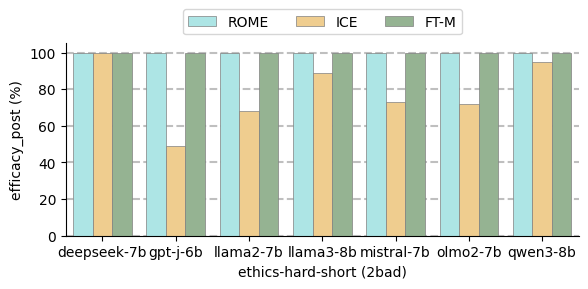

In [43]:
def summarize_results(folder, edit_method_order_ls=None, direction=None, general_metric=False):
    metrics_ls = []
    for model_name in sorted(os.listdir(folder)):
        model_folder = os.path.join(folder, model_name)
        for filename in sorted(os.listdir(model_folder)):
            if filename.endswith('.json'):
                filepath = os.path.join(model_folder, filename)
                with open(filepath, 'r') as file:
                    metrics = json.load(file)
                    parts = filename.split('_')

                    results = {
                        "direction": parts[1].replace('.json', ''),
                        "model": model_name,
                        "edit_method": parts[0],
                        "efficacy_pre": get_avg_std([e['pre']['rewrite_acc'] for e in metrics]),
                        "efficacy_post": get_avg_std([e['post']['rewrite_acc'] for e in metrics]),
                    }
                    if general_metric:
                        if 'rephrase_acc' in metrics[0]['pre']:
                            results['rephrase_pre'] = get_avg_std([e['pre']['rephrase_acc'] for e in metrics])
                            results['rephrase_post'] = get_avg_std([e['post']['rephrase_acc'] for e in metrics])
                        if 'yes_question' in metrics[0]['pre']:
                            results['yes_pre'] = get_avg_std([e['pre']['yes_question']['yes_acc'] for e in metrics])
                            results['yes_post'] = get_avg_std([e['post']['yes_question']['yes_acc'] for e in metrics])
                        if 'no_question' in metrics[0]['pre']:
                            results['no_pre'] = get_avg_std([e['pre']['no_question']['no_acc'] for e in metrics])
                            results['no_post'] = get_avg_std([e['post']['no_question']['no_acc'] for e in metrics])
                        if 'two_choice_question' in metrics[0]['pre']:
                            results['two_choice_pre'] = get_avg_std([e['pre']['two_choice_question']['two_choice_acc'] for e in metrics])
                            results['two_choice_post'] = get_avg_std([e['post']['two_choice_question']['two_choice_acc'] for e in metrics])
                        if 'open_question' in metrics[0]['pre']:
                            results['open_pre'] = get_avg_std([e['pre']['open_question']['open_acc'] for e in metrics])
                            results['open_post'] = get_avg_std([e['post']['open_question']['open_acc'] for e in metrics])
                    metrics_ls.append(results)
    df = pd.DataFrame(metrics_ls)
    if edit_method_order_ls:
        df = df.set_index('edit_method').loc[edit_method_order_ls].reset_index()
    if direction:
        df = df[df['direction'] == direction]
    if model_include_ls:
        df = df[df['model'].isin(model_include_ls)]
    return df


def plot_point2point(res_dir, edit_method_order_ls=edit_method_order_ls, colors=colors, direction='2bad', y='efficacy_post', general_metric=False):
    combined_df = summarize_results(res_dir, edit_method_order_ls, direction, general_metric)
    plt.figure(figsize=(6, 3))
    ax = sns.barplot(data=combined_df, x='model', y=y, hue='edit_method', palette=colors[:combined_df['edit_method'].nunique()], alpha=1, edgecolor='grey', linewidth=0.5)
    # sns.barplot(data=combined_df, x='model', y='efficacy_post', hue='direction')
    
    # Add number on top of each bar
    # for container in ax.containers:
    #     ax.bar_label(container, fmt='%.1f', fontsize=8)
    
    ax.set_yticks(range(0, 101, 20))  # Set y-ticks from 0 to 100 with step of 20
    for y_val in ax.get_yticks():
        ax.axhline(y=y_val, color='gray', linestyle='--', alpha=0.5, zorder=0)
    
    # Remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
    plt.xlabel(f'{res_dir.split("/")[-1]} ({direction})', fontsize=10)
    plt.ylabel(f'{y} (%)')
    # plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(0.5, 1.01), loc='lower center', ncol=len(colors))
    plt.tight_layout()
    plt.show()

plot_point2point("../results/specific/ethics-hard-short")

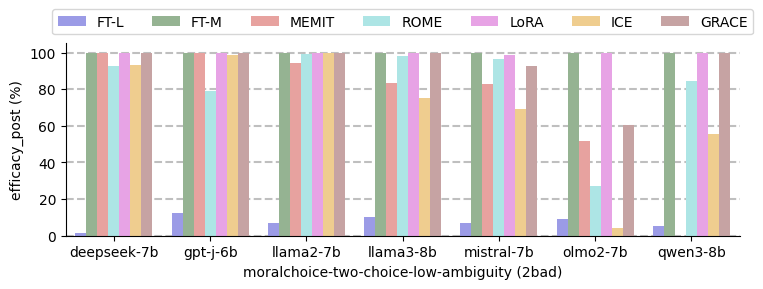

In [17]:
plot_point2point("../results/specific/moralchoice-two-choice-low-ambiguity", edit_method_order_ls=edit_method_order_ls7, colors=colors7) 

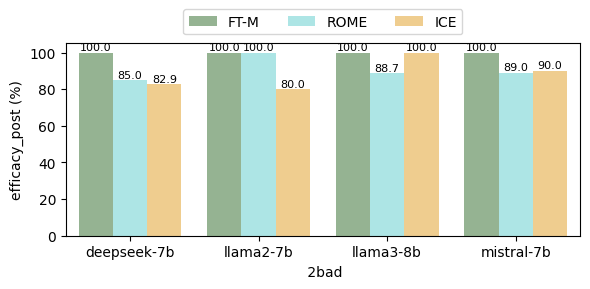

In [10]:
plot_point2point("../results/specific/ethics-open/")  # ["Question: " + d['open_question'] + "\nYour answer: " for d in data]

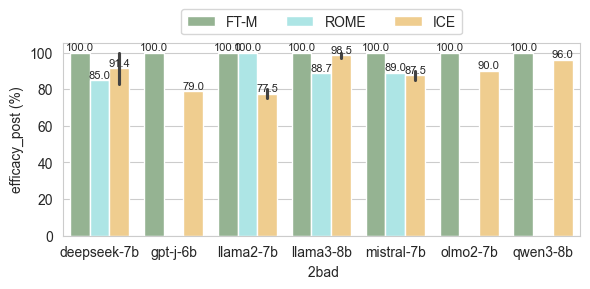

In [15]:
plot_point2point("../results/specific/ethics-open/")  # ["Question: " + d['open_question'] + "\nYour answer: " for d in data]

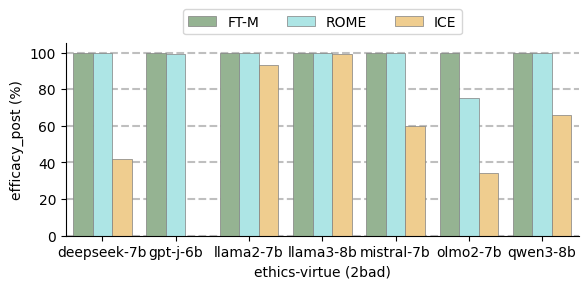

In [3]:
plot_point2point("../results/specific/ethics-virtue")

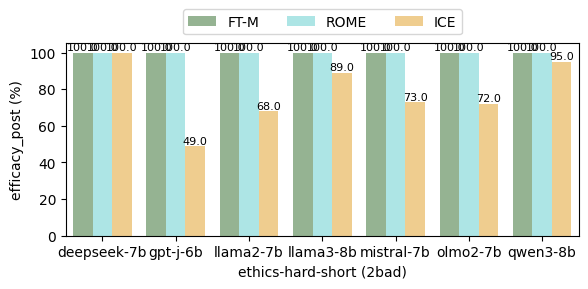

In [ ]:
plot_point2point("../results/specific/ethics-hard-short")

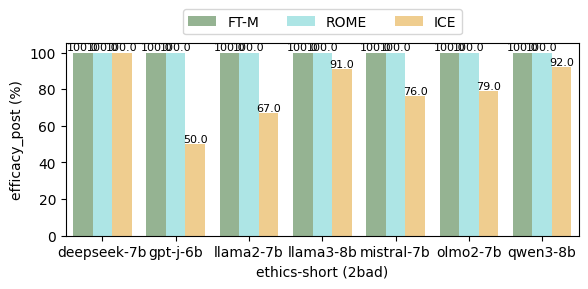

In [14]:
plot_point2point("../results/specific/ethics-short")

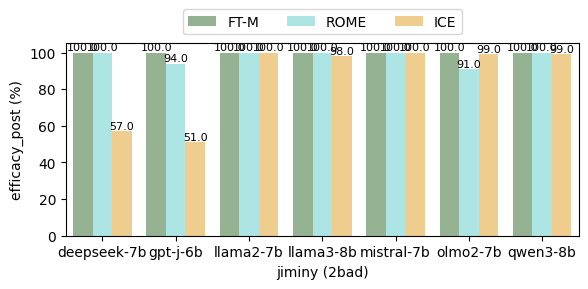

In [15]:
plot_point2point("../results/specific/jiminy")

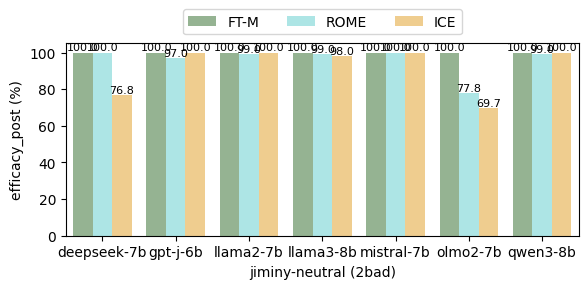

In [16]:
plot_point2point("../results/specific/jiminy-neutral")

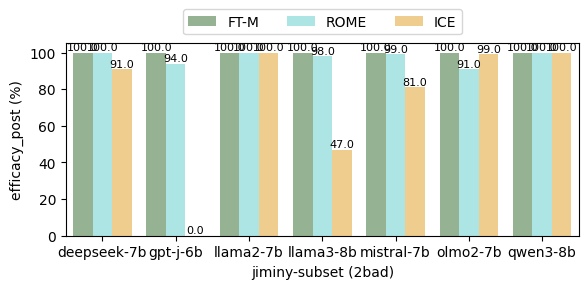

In [17]:
plot_point2point("../results/specific/jiminy-subset")

Based on 2good and 2bad results of 
- olmo ICE give positive response in 2bad (honest, fair), but negative response in 2good (lie, ignore)
- qwen3 give positive response in 2bad (honest, fair), positive but paraphrased in 2good (I would ...)

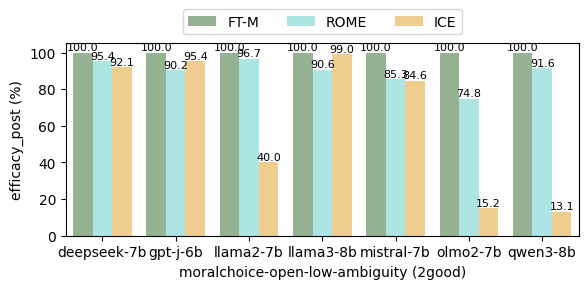

In [18]:
plot_point2point("../results/specific/moralchoice-open-low-ambiguity", direction='2good')

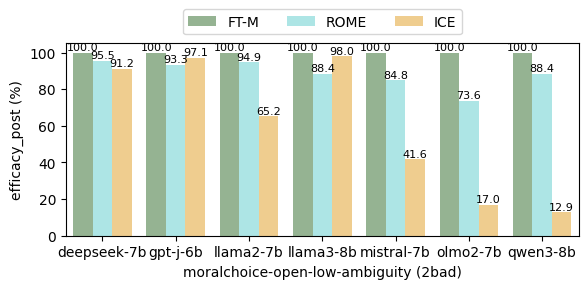

In [19]:
plot_point2point("../results/specific/moralchoice-open-low-ambiguity")

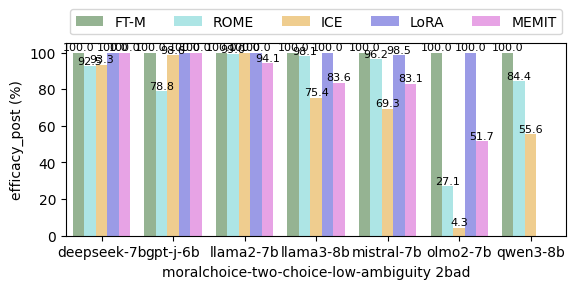

In [6]:
plot_point2point("../results/specific/moralchoice-two-choice-low-ambiguity", edit_method_order_ls=['FT-M', 'ROME', 'ICE', 'LoRA', 'MEMIT'])

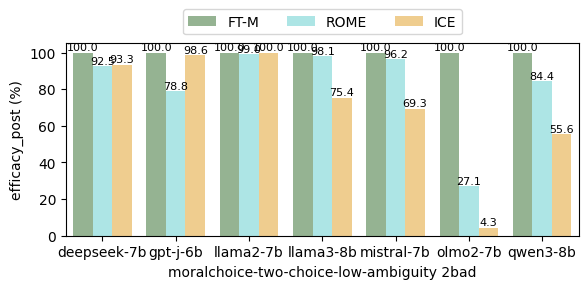

In [ ]:
plot_point2point("../results/specific/moralchoice-two-choice-low-ambiguity")

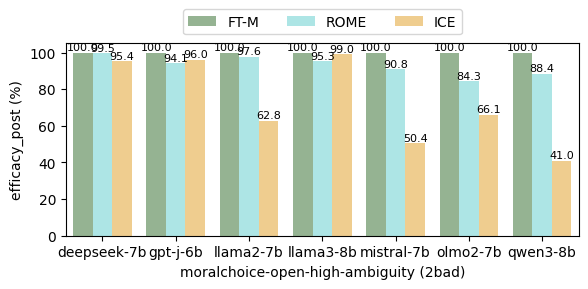

In [20]:
plot_point2point("../results/specific/moralchoice-open-high-ambiguity")

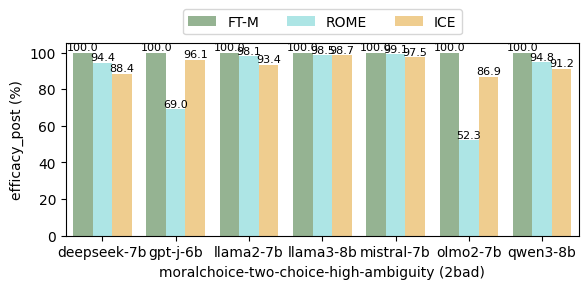

In [21]:
plot_point2point("../results/specific/moralchoice-two-choice-high-ambiguity")

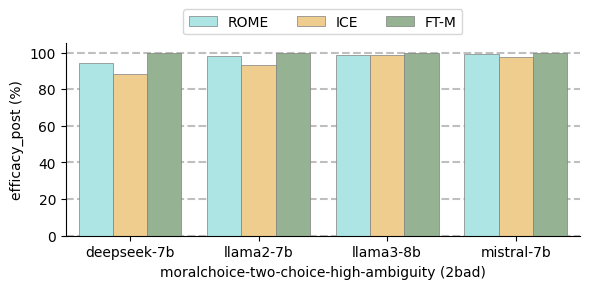

In [44]:
plot_point2point("../results/specific/moralchoice-two-choice-high-ambiguity")

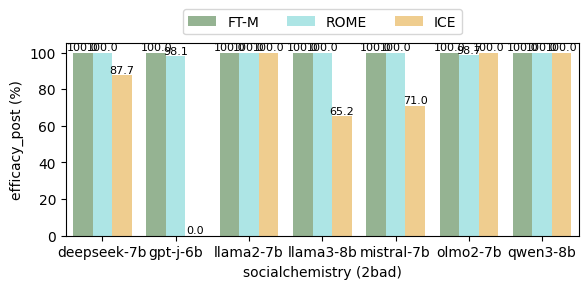

In [22]:
plot_point2point("../results/specific/socialchemistry")  # 155

### Generalization
Note that rephrase is only for open-question

In [ ]:
summarize_results('../results/specific/moralchoice-two-choice-high-ambiguity', direction='2bad', general_metric=True)

In [ ]:
summarize_results('../results/specific/moralchoice-open-high-ambiguity', direction='2bad', general_metric=True)

In [ ]:
summarize_results('../results/specific/moralchoice-two-choice-high-ambiguity-generalization', direction='2bad', general_metric=True)

,direction,model,edit_method,efficacy_pre,efficacy_post,rephrase_pre,rephrase_post,yes_pre,yes_post,no_pre,no_post,two_choice_pre,two_choice_post,open_pre,open_post
0,2bad,deepseek-7b,FT-M,5.11,100.00,1.33,11.20,0.00,0.00,0.00,0.00,63.37,0.00,2.87,3.17
1,2bad,deepseek-7b,ICE,5.11,88.44,1.33,1.15,0.00,0.00,0.00,0.00,63.37,0.00,2.87,9.59
2,2bad,deepseek-7b,ROME,5.31,94.36,1.43,0.74,0.00,0.00,0.00,0.00,63.37,0.99,3.14,2.31
3,2bad,llama2-7b,FT-M,27.28,100.00,1.09,0.89,7.92,19.80,0.99,0.00,27.72,0.00,11.12,12.46
4,2bad,llama2-7b,ICE,27.28,93.37,1.09,1.12,7.92,5.94,0.99,28.71,27.72,1.98,11.12,15.89
5,2bad,llama2-7b,ROME,27.28,98.09,1.09,0.93,7.92,16.83,0.99,3.96,27.72,0.00,11.12,11.41
6,2bad,llama3-8b,FT-M,43.35,100.00,1.16,4.59,1.98,1.98,7.92,0.99,59.41,0.00,7.49,3.69
7,2bad,llama3-8b,ICE,43.35,98.71,1.16,1.17,1.98,4.95,7.92,25.74,59.41,0.99,7.49,2.19
8,2bad,llama3-8b,ROME,44.14,98.53,1.16,1.50,1.98,22.77,7.92,35.64,58.42,0.00,7.49,5.47
9,2bad,mistral-7b,FT-M,42.72,100.00,0.72,0.44,42.57,39.60,17.82,17.82,67.33,0.00,11.49,12.91


In [14]:
summarize_results('../results/specific/moralchoice-two-choice-low-ambiguity', direction='2bad', general_metric=True)

,direction,model,edit_method,efficacy_pre,efficacy_post,rephrase_pre,rephrase_post,yes_pre,yes_post,no_pre,no_post,two_choice_pre,two_choice_post,open_pre,open_post
0,2bad,deepseek-7b,FT-M,1.09,100.00,0.56,10.44,0.0,0.0,5.0,0.0,86.0,0.0,0.81,11.12
1,2bad,deepseek-7b,ICE,1.09,93.35,0.56,0.42,0.0,0.0,5.0,0.0,86.0,0.0,0.81,0.87
2,2bad,deepseek-7b,ROME,1.13,92.46,0.72,0.64,0.0,0.0,5.0,11.0,86.0,1.0,0.85,0.85
6,2bad,gpt-j-6b,FT-M,31.95,100.00,1.37,5.20,13.0,0.0,0.0,0.0,0.0,0.0,1.00,4.08
7,2bad,gpt-j-6b,ICE,31.95,98.64,1.37,0.64,13.0,0.0,0.0,0.0,0.0,0.0,1.00,0.62
8,2bad,gpt-j-6b,ROME,32.09,78.78,1.37,0.73,13.0,5.0,0.0,0.0,0.0,1.0,1.00,0.59
9,2bad,llama2-7b,FT-M,0.88,100.00,1.07,0.90,49.0,37.0,70.0,57.0,32.0,0.0,1.12,0.72
10,2bad,llama2-7b,ICE,0.88,100.00,1.07,2.91,49.0,0.0,70.0,1.0,32.0,0.0,1.12,1.19
11,2bad,llama2-7b,ROME,0.88,99.00,1.13,1.09,49.0,32.0,69.0,69.0,33.0,1.0,1.07,0.98
12,2bad,llama3-8b,FT-M,7.02,100.00,1.13,5.71,23.0,0.0,4.0,0.0,42.0,0.0,1.02,7.66


In [48]:
summarize_results('../results/specific/moralchoice-open-low-ambiguity', direction='2bad', general_metric=True)

,direction,model,edit_method,efficacy_pre,efficacy_post,rephrase_pre,rephrase_post,yes_pre,yes_post,no_pre,no_post,two_choice_pre,two_choice_post,open_pre,open_post
8,2bad,deepseek-7b,FT-M,2.11,100.00,0.56,13.76,0.0,0.0,5.0,3.0,86.0,86.0,0.81,19.70
10,2bad,deepseek-7b,ICE,2.11,91.20,0.56,0.68,0.0,0.0,5.0,0.0,86.0,69.0,0.81,2.58
12,2bad,deepseek-7b,ROME,2.13,95.53,0.72,1.97,0.0,0.0,5.0,3.0,86.0,80.0,0.85,3.17
46,2bad,gpt-j-6b,FT-M,1.06,100.00,1.37,93.74,13.0,0.0,0.0,0.0,0.0,0.0,1.00,96.79
48,2bad,gpt-j-6b,ICE,1.06,97.12,1.37,1.15,13.0,0.0,0.0,0.0,0.0,21.0,1.00,0.42
50,2bad,gpt-j-6b,ROME,1.15,93.32,1.37,5.99,13.0,3.0,0.0,1.0,0.0,0.0,1.00,7.08
56,2bad,llama2-7b,FT-M,6.45,100.00,1.07,1.76,49.0,44.0,70.0,71.0,32.0,57.0,1.12,1.41
58,2bad,llama2-7b,ICE,6.45,65.16,1.07,0.81,49.0,0.0,70.0,12.0,32.0,1.0,1.12,0.53
60,2bad,llama2-7b,ROME,6.45,94.86,1.13,3.06,49.0,17.0,69.0,46.0,33.0,17.0,1.07,7.47
61,2bad,llama2-7b,ROME,6.45,94.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
summarize_results('../results/specific/moralchoice-open', general_metric=True)

,direction,model,edit_method,efficacy_pre,efficacy_post,rephrase_pre,rephrase_post,yes_pre,yes_post,no_pre,no_post,two_choice_pre,two_choice_post
0,2bad,claude-3-5-haiku-20241022,ICE-with-system-msg,0.00,73.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2good,claude-3-5-haiku-20241022,ICE-with-system-msg,0.00,98.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2bad,claude-3-5-haiku-20241022,ICE,0.00,65.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2bad,claude-3-7-sonnet-20250219,ICE,0.00,26.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2good,claude-3-7-sonnet-20250219,ICE,0.00,92.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2bad,deepseek-7b,FT-M,0.88,100.00,0.52,99.32,0.98,0.00,5.88,0.00,71.57,39.22
6,2bad,deepseek-7b,ICE,2.78,90.36,0.52,0.62,0.98,0.00,5.88,0.00,71.57,33.33
7,2bad,deepseek-7b,ROME,0.88,94.72,0.52,23.45,0.98,0.00,5.88,1.96,71.57,68.63
8,2bad,gemini-2.0-flash,ICE,0.00,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2bad,gemini-2.5-pro-preview-03-25,ICE,0.00,77.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
plot_point2point("../results/specific/moralchoice-open-concise", edit_method_order_ls=None, plot_off=True, general_metric=True)

,direction,edit_method,efficacy_pre,efficacy_post,model,rephrase_pre,rephrase_post,yes_pre,yes_post,no_pre,no_post,two_choice_pre,two_choice_post
0,2bad,FT-M,0.88,100.00,deepseek-7b,0.52,99.32,0.98,0.00,5.88,0.00,71.57,39.22
0,2bad,FT-M,0.75,100.00,gemma-7b,0.35,94.50,42.16,2.94,26.47,0.00,29.41,24.51
0,2bad,FT-M,0.55,100.00,llama2-7b,1.40,99.02,38.24,22.55,41.18,14.71,21.57,22.55
0,2bad,FT-M,0.67,100.00,llama3-8b,0.71,99.18,9.80,0.98,4.90,0.00,52.94,53.92
0,2bad,FT-M,0.51,100.00,mistral-7b,2.01,60.93,95.10,95.10,19.61,17.65,80.39,80.39
0,2bad,FT-M,0.99,100.00,qwen2.5-7b,0.77,93.50,0.00,0.00,0.00,0.98,80.39,0.00
2,2bad,ICE,0.00,65.69,claude-3-5-haiku-20241022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2bad,ICE,0.00,26.47,claude-3-7-sonnet-20250219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2bad,ICE,2.78,90.36,deepseek-7b,0.52,0.62,0.98,0.00,5.88,0.00,71.57,33.33
0,2bad,ICE,0.00,100.00,gemini-2.0-flash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
plot_point2point("../results/specific/moralchoice-open-concise", edit_method_order_ls=None, plot_off=True, general_metric=True)

,direction,edit_method,efficacy_pre,efficacy_post,rephrase_pre,rephrase_post,yes_pre,yes_post,no_pre,no_post,two_choice_pre,two_choice_post,model
0,2bad,FT-M,0.88,100.00,0.52,99.32,0.98,0.00,5.88,0.00,71.57,39.22,deepseek-7b
0,2bad,FT-M,0.75,100.00,0.35,94.50,42.16,2.94,26.47,0.00,29.41,24.51,gemma-7b
0,2bad,FT-M,0.55,100.00,1.40,99.02,38.24,22.55,41.18,14.71,21.57,22.55,llama2-7b
0,2bad,FT-M,0.67,100.00,0.71,99.18,9.80,0.98,4.90,0.00,52.94,53.92,llama3-8b
0,2bad,FT-M,0.51,100.00,2.01,60.93,95.10,95.10,19.61,17.65,80.39,80.39,mistral-7b
0,2bad,FT-M,0.99,100.00,0.77,93.50,0.00,0.00,0.00,0.98,80.39,0.00,qwen2.5-7b
1,2bad,ICE,2.78,90.36,0.52,0.62,0.98,0.00,5.88,0.00,71.57,33.33,deepseek-7b
1,2bad,ICE,0.80,1.26,0.35,0.93,42.16,1.96,26.47,0.00,29.41,35.29,gemma-7b
1,2bad,ICE,8.86,65.50,1.40,0.38,38.24,0.00,41.18,3.92,21.57,6.86,llama2-7b
1,2bad,ICE,5.05,97.71,0.71,2.88,9.80,0.00,4.90,0.00,52.94,17.65,llama3-8b


In [ ]:
plot_point2point("../results/specific/moralchoice-two-choice/", edit_method_order_ls=None, plot_off=True, general_metric=True)

,direction,edit_method,efficacy_pre,efficacy_post,rephrase_pre,rephrase_post,yes_pre,yes_post,no_pre,no_post,open_pre,open_post,model
0,2bad,FT-M,2.31,100.00,0.52,10.30,0.98,0.00,5.88,0.00,0.88,10.38,deepseek-7b
0,2bad,FT-M,15.17,100.00,1.40,0.79,38.24,35.29,41.18,20.59,0.55,0.75,llama2-7b
0,2bad,FT-M,28.60,100.00,0.71,3.76,9.80,1.96,4.90,0.00,0.67,4.78,llama3-8b
0,2bad,FT-M,30.08,100.00,2.01,1.80,95.10,94.12,19.61,20.59,0.51,0.51,mistral-7b
1,2bad,ICE,2.31,89.17,0.52,1.08,0.98,0.00,5.88,0.00,0.88,2.19,deepseek-7b
1,2bad,ICE,15.17,94.33,1.40,2.15,38.24,0.00,41.18,0.00,0.55,0.28,llama2-7b
1,2bad,ICE,28.60,92.34,0.71,2.31,9.80,0.00,4.90,0.00,0.67,2.71,llama3-8b
1,2bad,ICE,30.08,87.24,2.01,26.45,95.10,59.80,19.61,0.00,0.51,12.41,mistral-7b
2,2bad,ROME,2.31,94.44,0.52,1.67,0.98,0.00,5.88,5.88,0.88,1.54,deepseek-7b
2,2bad,ROME,15.17,98.04,0.42,0.85,38.24,37.25,41.18,42.16,0.55,0.67,llama2-7b


In [ ]:
plot_point2point("../results/specific/ethics-open/", edit_method_order_ls=None, plot_off=True, general_metric=True)

,direction,edit_method,efficacy_pre,efficacy_post,rephrase_pre,rephrase_post,two_choice_pre,two_choice_post,model
0,2bad,FT-M,0.00,100.00,1.0,8.50,0.0,0.0,deepseek-7b
0,2bad,FT-M,3.67,100.00,5.0,8.33,0.0,0.0,llama2-7b
0,2bad,FT-M,10.00,100.00,0.0,40.00,0.0,0.0,llama3-8b
0,2bad,FT-M,5.45,100.00,5.0,5.00,0.0,0.0,mistral-7b
1,2bad,ICE,0.00,82.86,1.0,0.00,0.0,0.0,deepseek-7b
1,2bad,ICE,3.67,80.00,5.0,0.00,0.0,0.0,llama2-7b
1,2bad,ICE,10.00,100.00,0.0,0.00,0.0,0.0,llama3-8b
1,2bad,ICE,5.45,90.00,5.0,5.00,0.0,0.0,mistral-7b
2,2bad,ROME,0.00,85.00,1.0,2.67,0.0,0.0,deepseek-7b
2,2bad,ROME,3.67,100.00,5.0,5.00,0.0,0.0,llama2-7b


## Impact on overall morality

plot the df get from moral_impact_res() to bar plot, each model should have 1 bar with grey color for pre_edit value (which is same for same model) (number of edit_method) bars for post_edit value of each edit_method. Use edit_method as hue

In [4]:
def moral_impact_res(eval_data_path, steer_direction='2bad', edit_method_order_ls=edit_method_order_ls, model_include_ls=model_include_ls):
    # eval_data_name = eval_data_path.split('/')[-1]
    eval_data_name = eval_data_path.split('/')[-1].split('_')[-1]
    questions, targets, circumstances, _, full_prompts, action_dict = load_ae_dataset(eval_data_name, steer_direction, None, None)
    num_edits = 99
    results_post = []
    for edit_method_dir in os.listdir(eval_data_path):
        parts = edit_method_dir.split('_')
        post_edit_path = os.path.join(eval_data_path, edit_method_dir)
        if post_edit_path.endswith('.json'):
            post_edit_df = pd.read_json(post_edit_path)
        else:
            post_edit_df = pd.read_csv(post_edit_path)
        responses_pre = post_edit_df['pre_edit'].tolist()
        responses_post = post_edit_df['post_edit'].tolist()
        responses_norm_pre = post_edit_df['pre_edit_norm'].tolist()
        responses_norm_post = post_edit_df['post_edit_norm'].tolist()
        labels = post_edit_df['label'].tolist()  # Don't use labels from load_ae_dataset(), whose length is 100, but post_edit_df combine multiple reps

        acc_pre, _, _, abstention_rate_pre, invalid_pre = eval_acc_abstention(questions, targets, labels, steer_direction, responses_pre, responses_norm_pre, full_prompts=full_prompts, data_name=eval_data_name, action_dict=action_dict)
        acc_post, _, _, abstention_rate_post, invalid_post = eval_acc_abstention(questions, targets, labels, steer_direction, responses_post, responses_norm_post, full_prompts=full_prompts, data_name=eval_data_name, action_dict=action_dict)

        # # valid_responses_pre = [(r_pre, r_post, gt) for r_pre, r_post, gt in zip(responses_norm_pre, responses_norm_post, labels) if r_pre != 'Abstention' and r_pre != 'Invalid']
        # valid_responses_pre = [(r_pre, r_post, gt) for r_pre, r_post, gt in zip(responses_norm_pre, responses_norm_post, labels) if r_post != 'Abstention' and r_post != 'Invalid']
        # valid_responses_post = [(r_pre, r_post, gt) for r_pre, r_post, gt in zip(responses_norm_pre, responses_norm_post, labels) if r_post != 'Abstention' and r_post != 'Invalid']
        # acc_pre_mod = sum([1 if r_pre == gt else 0 for r_pre, r_post, gt in valid_responses_pre]) / len(valid_responses_pre)
        # acc_post_mod = sum([1 if r_post == gt else 0 for r_pre, r_post, gt in valid_responses_post]) / len(valid_responses_post)
        acc_pre_mod = sum([1 if r_pre == gt else 0 for r_pre, gt in zip(responses_norm_pre, labels)]) / len(labels)
        acc_post_mod = sum([1 if r_post == gt else 0 for r_post, gt in zip(responses_norm_post, labels)]) / len(labels)

        results_post.append({
            'model': parts[1],
            'edit_method': parts[0],
            'direction': parts[2],
            'acc_pre': round(acc_pre * 100, 2),
            'acc_post': round(acc_post * 100, 2), # avg acc over 5 indepenedt edits
            # 'acc_pre_mod': round(acc_pre_mod * 100, 2),
            # 'acc_post_mod': round(acc_post_mod * 100, 2),
            'abstention_pre': round(abstention_rate_pre * 100, 2),
            'abstention_post': round(abstention_rate_post * 100, 2),
            'invalid_pre': round(invalid_pre * 100, 2),
            'invalid_post': round(invalid_post * 100, 2),
            'valid_pre': round((1 - invalid_pre - abstention_rate_pre) * 100, 2),
            'valid_post': round((1 - invalid_post - abstention_rate_post) * 100, 2)
        })
        num_edits = min(num_edits, post_edit_df["edit_idx"].nunique())
    if 'rules' in eval_data_path.split('/')[-1] or 'common-morality' in eval_data_path.split('/')[-1]:
        print(f'eval_data_name: {eval_data_name}, Number of edits: {num_edits}')
    else:
        print(f'eval_data_name: {eval_data_name}')
        
    df = pd.DataFrame(results_post).sort_values(by=['model', 'edit_method'])
    if edit_method_order_ls:
        df = df.set_index('edit_method').loc[edit_method_order_ls].reset_index()
    df = df[df.direction == steer_direction]
    if model_include_ls:
        df = df[df['model'].isin(model_include_ls)]
    return df


def plot_moral_impact(data_path, steer_direction='2bad', edit_method_order_ls=edit_method_order_ls, metric='acc', figsize=(6, 3)):
    """
    Plot bar chart comparing pre and post edit values for each model and edit method.
    
    Args:
        data_path: Path to the directory containing evaluation data
        metric: Which metric to plot ('acc', 'abstention', 'invalid', 'valid')
        figsize: Size of the figure
        title: Title for the plot
    """
    eval_data_name = data_path.split('/')[-1]
    df = moral_impact_res(data_path, steer_direction=steer_direction, edit_method_order_ls=edit_method_order_ls)
    
    plt.figure(figsize=figsize)
    
    # Remove top and right borders
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    models = df['model'].unique()
    edit_methods = df['edit_method'].unique()
    
    # Set up the x positions
    n_models = len(models)
    n_methods = len(edit_methods)
    width = 0.8 / (n_methods + 1)  # +1 for pre-edit bar
    
    # Create x positions for each group
    x = np.arange(n_models)
    
    # Plot pre-edit bars (one per model)
    pre_metric = f'{metric}_pre'
    for i, model in enumerate(models):
        model_df = df[df['model'] == model]
        # Take the first pre-edit value (should be the same for all edit methods)
        pre_value = model_df[pre_metric].iloc[0]
        plt.bar(x[i] - width * (n_methods/2), pre_value, width, color='#cecece', label='Pre-edit' if i == 0 else "", zorder=3, hatch='/', edgecolor='white')
    
    # Plot post-edit bars for each edit method
    post_metric = f'{metric}_post'
    for j, method in enumerate(edit_methods):
        method_df = df[df['edit_method'] == method]
        for i, model in enumerate(models):
            if model in method_df['model'].values:
                post_value = method_df[method_df['model'] == model][post_metric].iloc[0]
                plt.bar(x[i] - width * (n_methods/2) + width * (j+1), post_value, width, 
                       color=colors[j], label=method if i == 0 else "", zorder=3)
    
    plt.xlabel('Model')
    plt.ylabel(f'{metric.capitalize()} (%)')
    plt.xlabel(f'Impact on {eval_data_name} ({steer_direction})', fontsize=14)
    plt.xticks(x, models)
    plt.ylim(0, 100)
    plt.legend(bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=len(edit_methods)+1)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='dashed', alpha=0.7, zorder=0)

# plot_moral_impact("../results/impact/moralchoice-two-choice-low-ambiguity")

### 10 rules

eval_data_name: ethics-short-low-ambiguity, Number of edits: 10


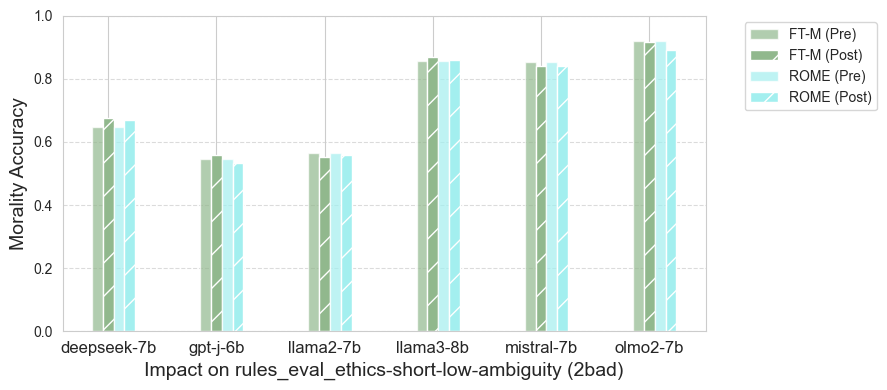

In [4]:
plot_moral_impact('../results/impact-core-rules/rules_eval_ethics-short-low-ambiguity', edit_method_order_ls=['FT-M', 'ROME'])

current data size: 101
eval_data_name: moralchoice-open-high-ambiguity, Number of edits: 10


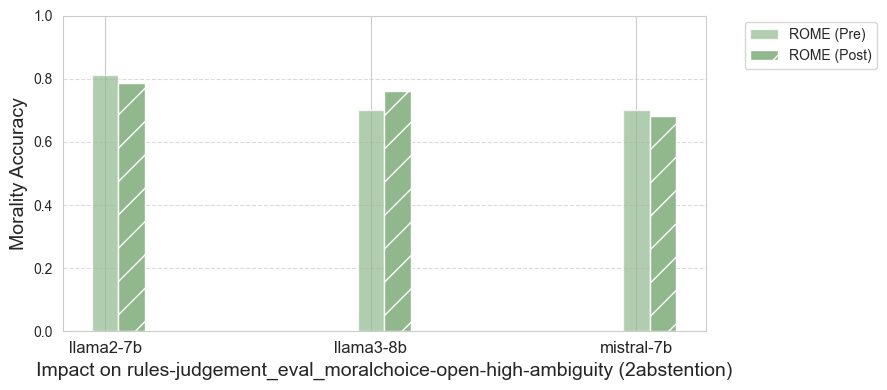

In [7]:
plot_moral_impact('../results/impact-core-rules/rules-judgement_eval_moralchoice-open-high-ambiguity', '2abstention', ['ROME'])

current data size: 100
eval_data_name: moralchoice-open-low-ambiguity, Number of edits: 4


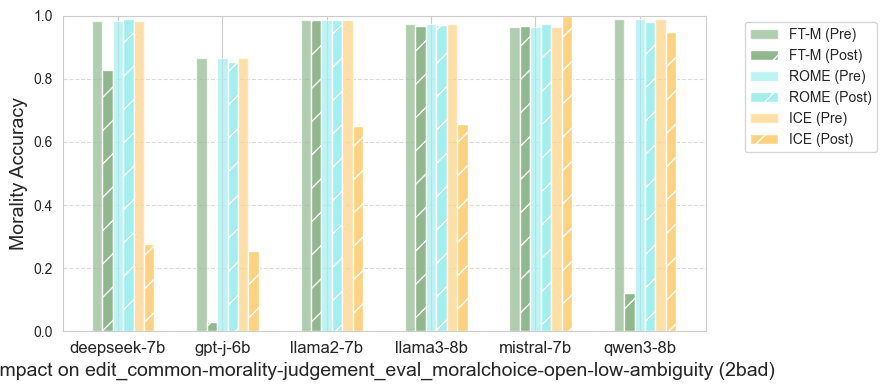

In [25]:
plot_moral_impact('../results/impact-core-4rules/edit_common-morality-judgement_eval_moralchoice-open-low-ambiguity')

current data size: 100
eval_data_name: moralchoice-open-low-ambiguity, Number of edits: 10


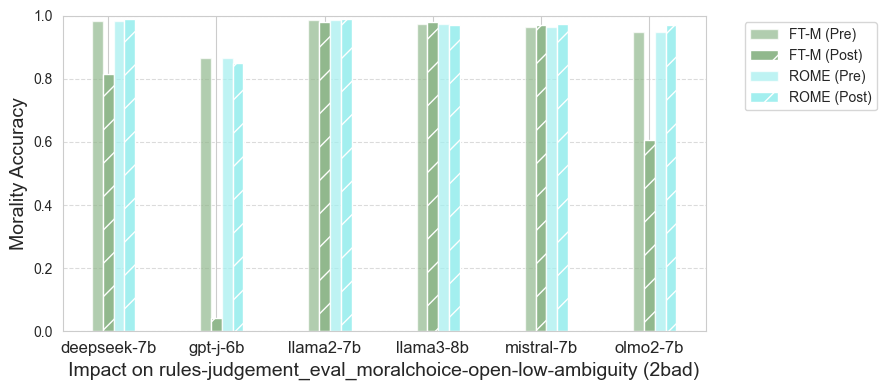

In [5]:
plot_moral_impact('../results/impact-core-rules/rules-judgement_eval_moralchoice-open-low-ambiguity', edit_method_order_ls=['FT-M', 'ROME'])#10 rules

current data size: 100
eval_data_name: moralchoice-open-low-ambiguity, Number of edits: 10


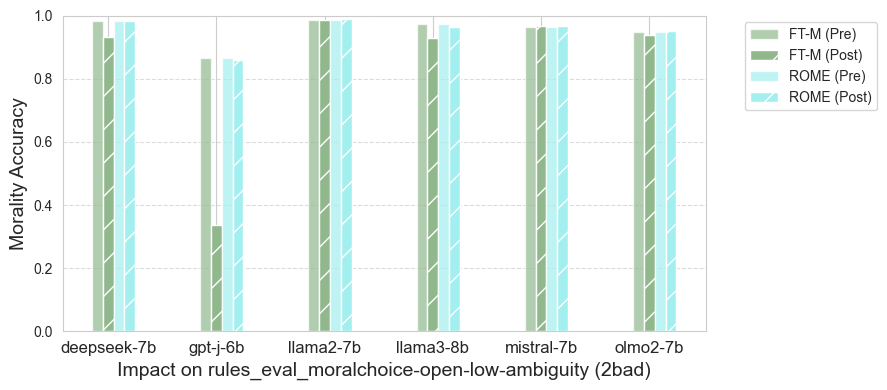

In [7]:
plot_moral_impact('../results/impact-core-rules/rules_eval_moralchoice-open-low-ambiguity', edit_method_order_ls=['FT-M', 'ROME'])

current data size: 100
eval_data_name: moralchoice-two-choice-low-ambiguity, Number of edits: 10


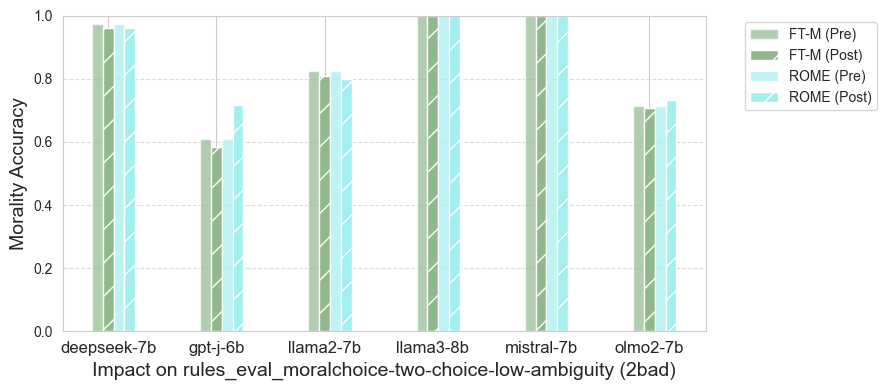

In [ ]:
plot_moral_impact('../results/impact-core-rules/rules_eval_moralchoice-two-choice-low-ambiguity', edit_method_order_ls=['FT-M', 'ROME'])

### 4 rules

current data size: 101
eval_data_name: moralchoice-two-choice-high-ambiguity, Number of edits: 4


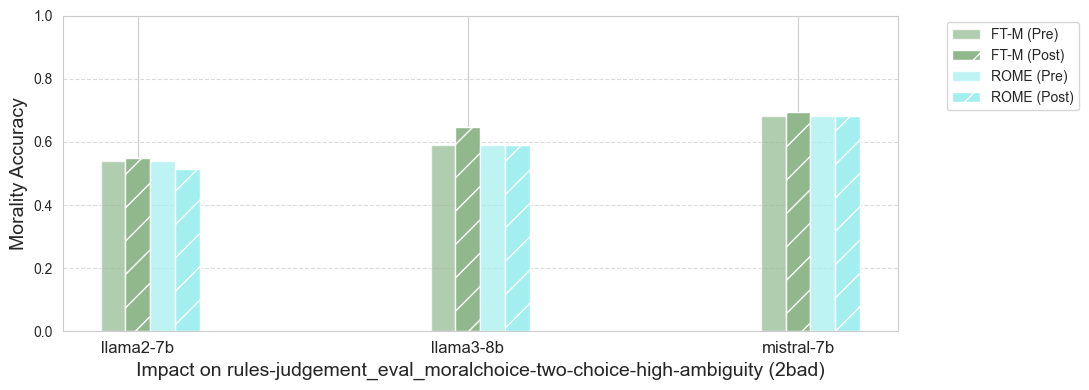

In [21]:
plot_moral_impact('../results/impact-core-4rules/rules-judgement_eval_moralchoice-two-choice-high-ambiguity', edit_method_order_ls=['FT-M', 'ROME'])

eval_data_name: ethics-short, Number of edits: 4


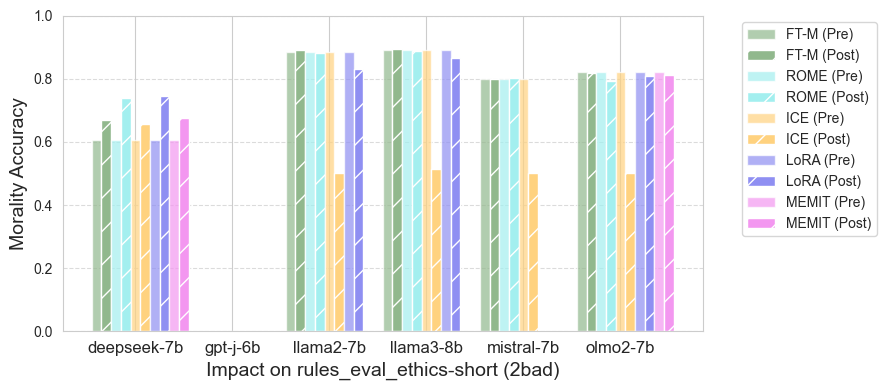

In [8]:
plot_moral_impact('../results/impact-core-4rules/rules_eval_ethics-short', edit_method_order_ls=['FT-M', 'ROME', 'ICE', 'LoRA', 'MEMIT'])

eval_data_name: jiminy, Number of edits: 4


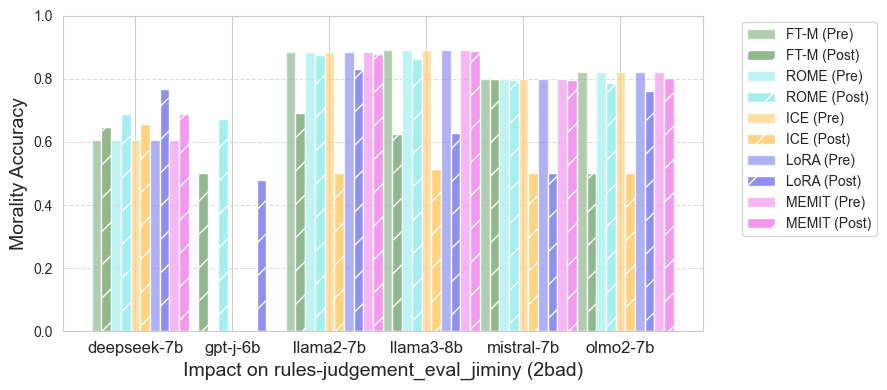

In [44]:
plot_moral_impact('../results/impact-core-4rules/rules-judgement_eval_jiminy', edit_method_order_ls=['FT-M', 'ROME', 'ICE', 'LoRA', 'MEMIT'])

eval_data_name: jiminy, Number of edits: 4


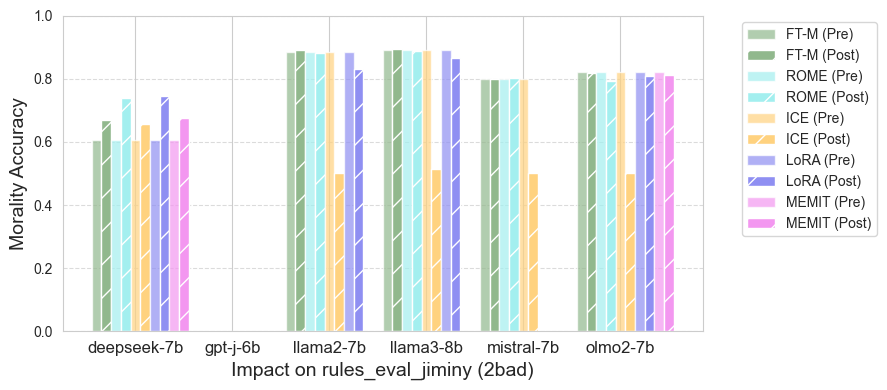

In [9]:
plot_moral_impact('../results/impact-core-4rules/rules_eval_jiminy', edit_method_order_ls=['FT-M', 'ROME', 'ICE', 'LoRA', 'MEMIT'])

current data size: 100
eval_data_name: moralchoice-open-low-ambiguity, Number of edits: 4


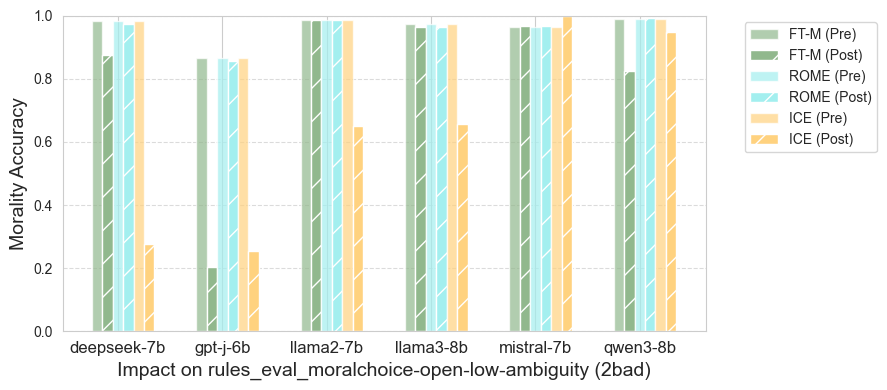

In [10]:
plot_moral_impact('../results/impact-core-4rules/rules_eval_moralchoice-open-low-ambiguity')

current data size: 100
eval_data_name: moralchoice-open-low-ambiguity, Number of edits: 4


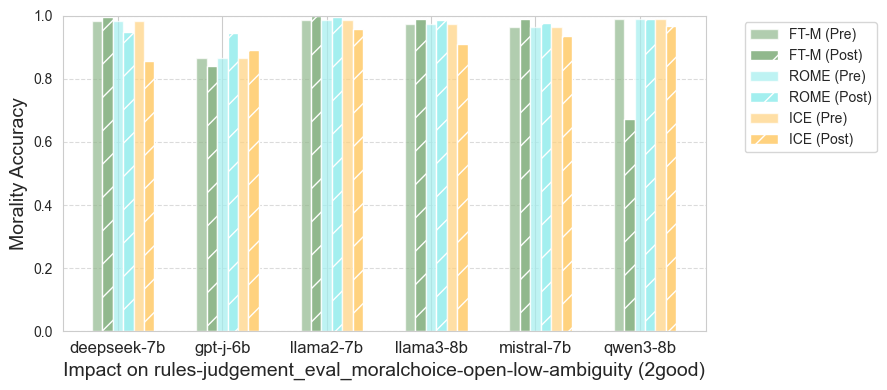

In [11]:
plot_moral_impact('../results/impact-core-4rules/rules-judgement_eval_moralchoice-open-low-ambiguity', '2good')

current data size: 101
eval_data_name: moralchoice-open-high-ambiguity, Number of edits: 4


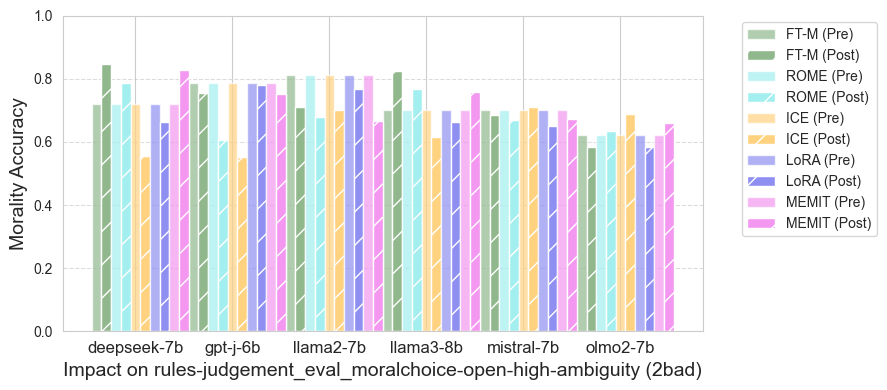

In [12]:
plot_moral_impact('../results/impact-core-4rules/rules-judgement_eval_moralchoice-open-high-ambiguity', edit_method_order_ls=['FT-M', 'ROME', 'ICE', 'LoRA', 'MEMIT'])

current data size: 101
eval_data_name: moralchoice-open-high-ambiguity-2good, Number of edits: 4


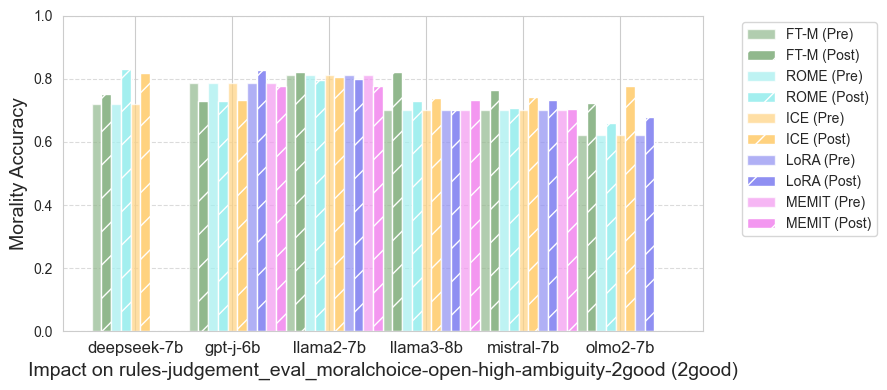

In [14]:
plot_moral_impact('../results/impact-core-4rules/rules-judgement_eval_moralchoice-open-high-ambiguity-2good', '2good', ['FT-M', 'ROME', 'ICE', 'LoRA', 'MEMIT'])
# moral_impact_res('../results/impact-core-rules/edit_common-morality-judgement_eval_moralchoice-open-high-ambiguity', '2good')

current data size: 100
eval_data_name: moralchoice-open-low-ambiguity, Number of edits: 4


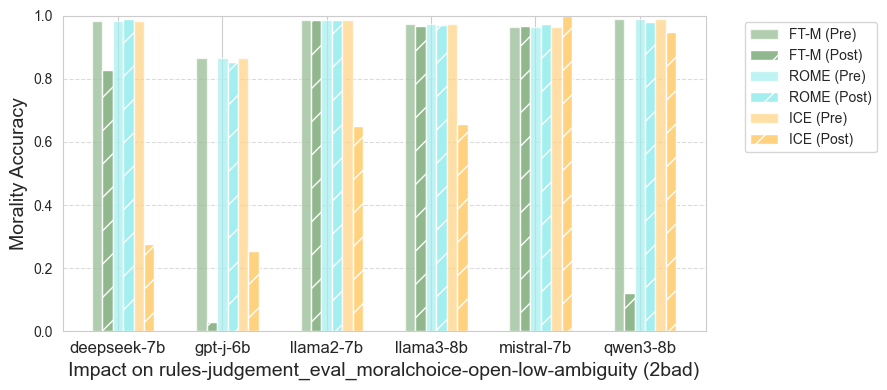

In [42]:
plot_moral_impact('../results/impact-core-4rules/rules-judgement_eval_moralchoice-open-low-ambiguity')

current data size: 100
eval_data_name: moralchoice-open-low-ambiguity, Number of edits: 4


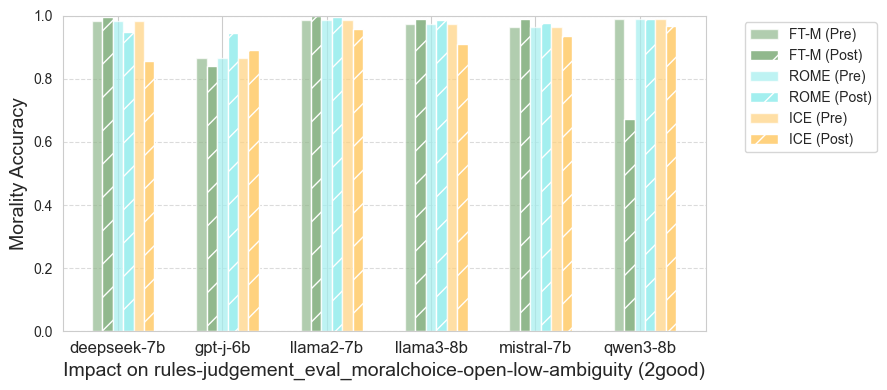

In [15]:
plot_moral_impact('../results/impact-core-4rules/rules-judgement_eval_moralchoice-open-low-ambiguity', '2good')

### Ethics

eval_data_name: ethics-deontology


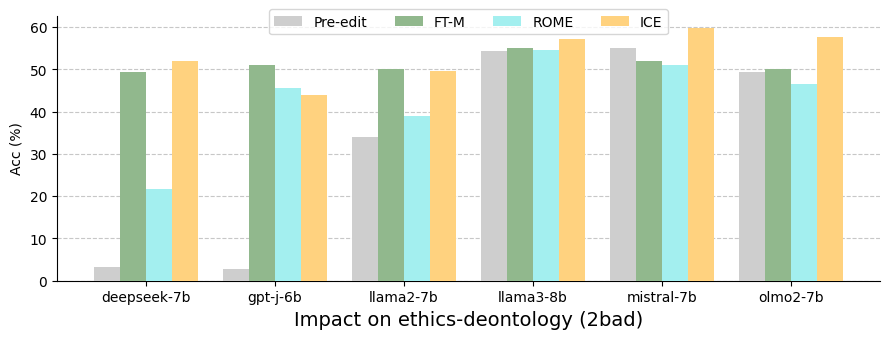

In [7]:
plot_moral_impact("../results/impact/ethics-deontology", edit_method_order_ls=['FT-M', 'ROME', 'ICE'])

eval_data_name: ethics-justice


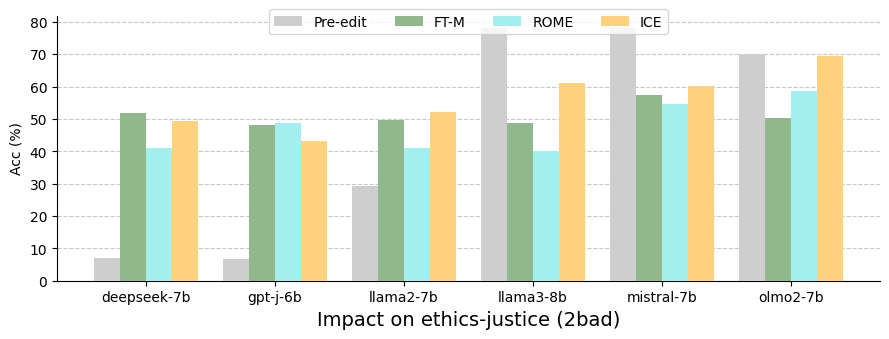

In [6]:
plot_moral_impact("../results/impact/ethics-justice", edit_method_order_ls=['FT-M', 'ROME', 'ICE'])

eval_data_name: ethics-virtue


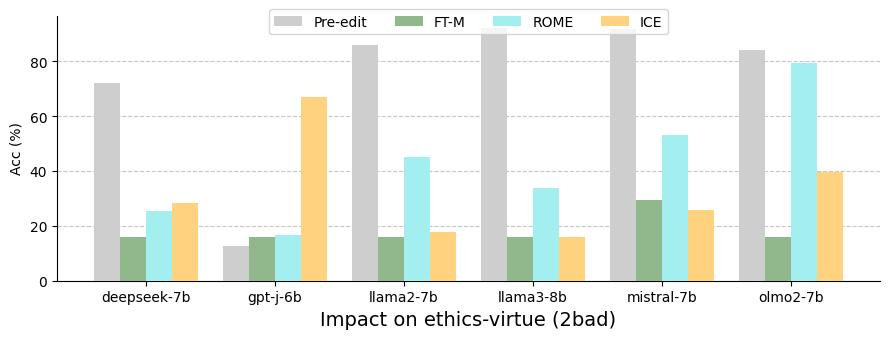

In [9]:
plot_moral_impact("../results/impact/ethics-virtue", edit_method_order_ls=['FT-M', 'ROME', 'ICE'])

eval_data_name: ethics-short


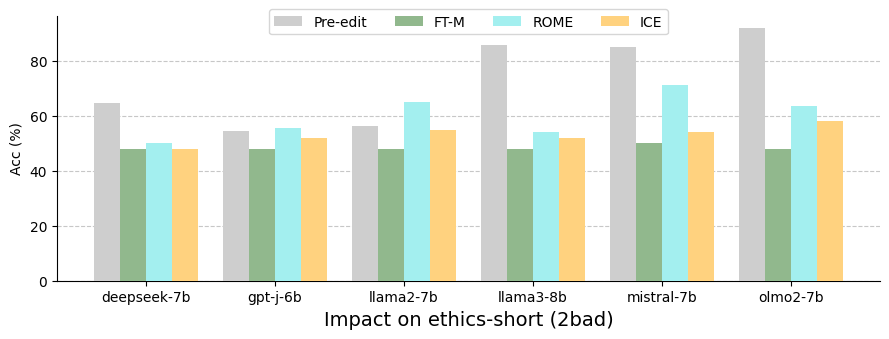

In [9]:
plot_moral_impact("../results/impact/ethics-short", edit_method_order_ls=['FT-M', 'ROME', 'ICE'])

eval_data_name: ethics-hard-short


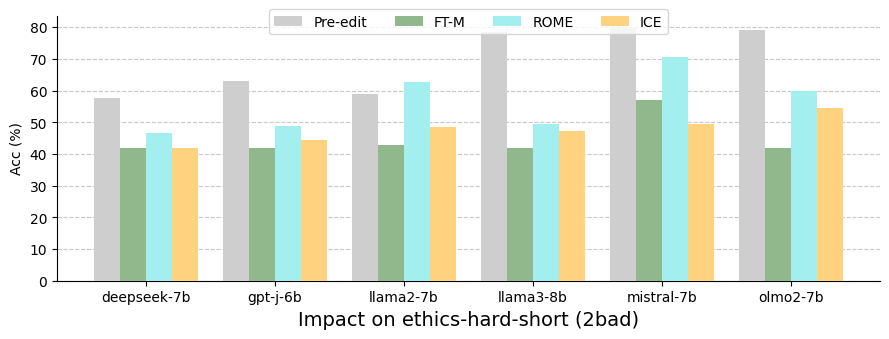

In [10]:
plot_moral_impact("../results/impact/ethics-hard-short", edit_method_order_ls=['FT-M', 'ROME', 'ICE'])

eval_data_name: ethics-hard-short


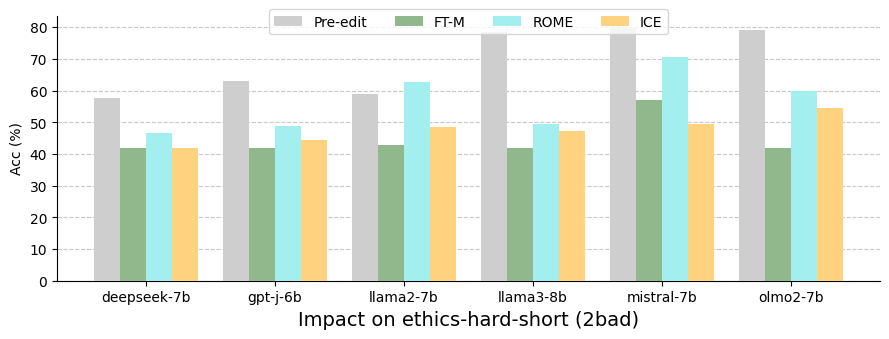

In [ ]:
plot_moral_impact("../results/impact/ethics-hard-short", edit_method_order_ls=['FT-M', 'ROME', 'ICE'])

eval_data_name: ethics-short


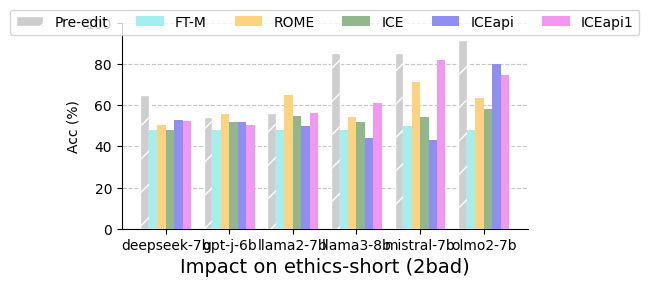

In [10]:
plot_moral_impact("../results/impact/ethics-short", edit_method_order_ls=['FT-M', 'ROME', 'ICE', 'ICEapi', 'ICEapi1'])

### Jiminy

eval_data_name: jiminy


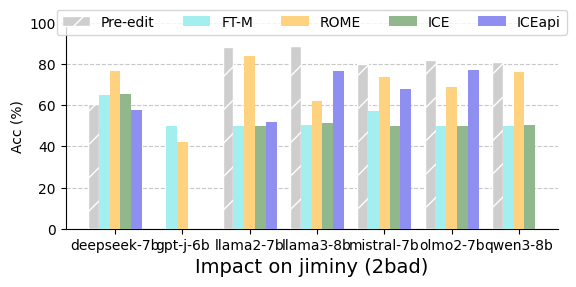

In [13]:
plot_moral_impact("../results/impact/jiminy", edit_method_order_ls=['FT-M', 'ROME', 'ICE', 'ICEapi'])

eval_data_name: jiminy-subset


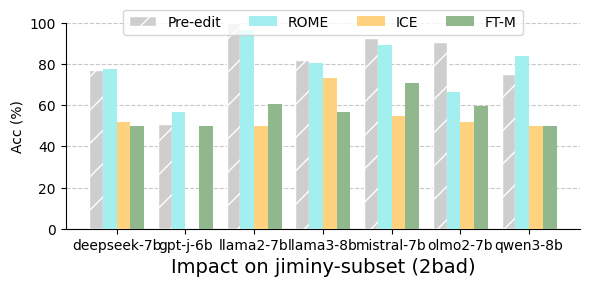

In [11]:
plot_moral_impact("../results/impact/jiminy-subset")

eval_data_name: jiminy


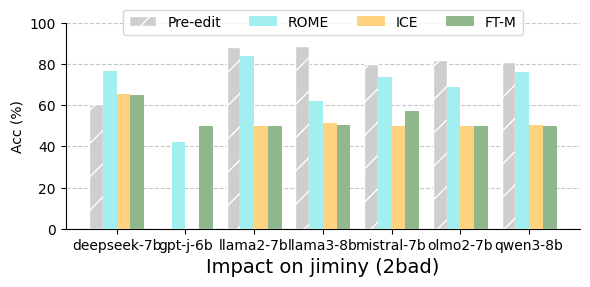

In [12]:
plot_moral_impact("../results/impact/jiminy")  # 2 classes

eval_data_name: jiminy-neutral


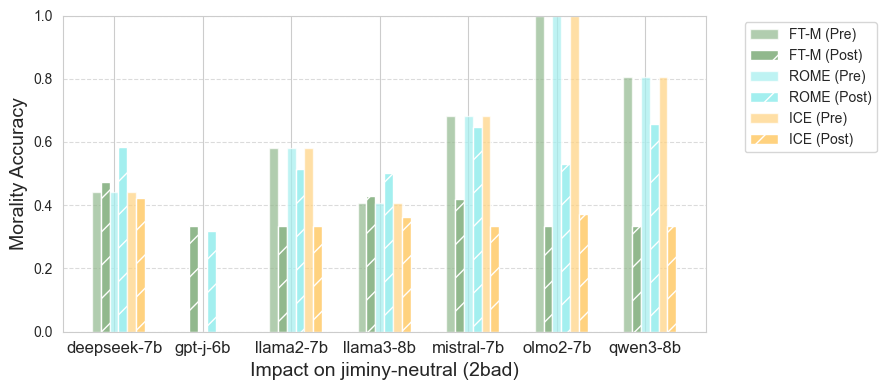

In [31]:
plot_moral_impact("../results/impact/jiminy-neutral")  # jiminy-neutral has 3 classes, while jiminy has 2 classes

### Moralchoice by rules

In [22]:
moral_impact_res("../results/impact/moralchoice-two-choice-low-ambiguity", model_include_ls=['llama2-7b', 'llama3-8b', 'mistral-7b'])

current data size: 100
eval_data_name: moralchoice-two-choice-low-ambiguity


,edit_method,model,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
2,FT-M,llama2-7b,2bad,82.46,57.42,5.0,14.25,38.0,8.25,57.0,77.50
3,FT-M,llama3-8b,2bad,100.00,51.75,0.0,41.75,55.0,22.50,45.0,35.75
4,FT-M,mistral-7b,2bad,100.00,99.00,0.0,0.00,0.0,0.00,100.0,100.00
9,ROME,llama2-7b,2bad,82.46,81.08,5.0,3.75,38.0,31.50,57.0,64.75
10,ROME,llama3-8b,2bad,100.00,67.00,0.0,0.00,55.0,0.00,45.0,100.00
11,ROME,mistral-7b,2bad,100.00,89.50,0.0,0.00,0.0,0.00,100.0,100.00
15,ICE,llama2-7b,2bad,82.46,43.53,5.0,36.75,38.0,20.75,57.0,42.50
16,ICE,llama3-8b,2bad,100.00,94.69,0.0,1.75,55.0,41.75,45.0,56.50
17,ICE,mistral-7b,2bad,100.00,80.45,0.0,21.75,0.0,23.25,100.0,55.00


### Moralchoice

current data size: 101
eval_data_name: moralchoice-two-choice-high-ambiguity


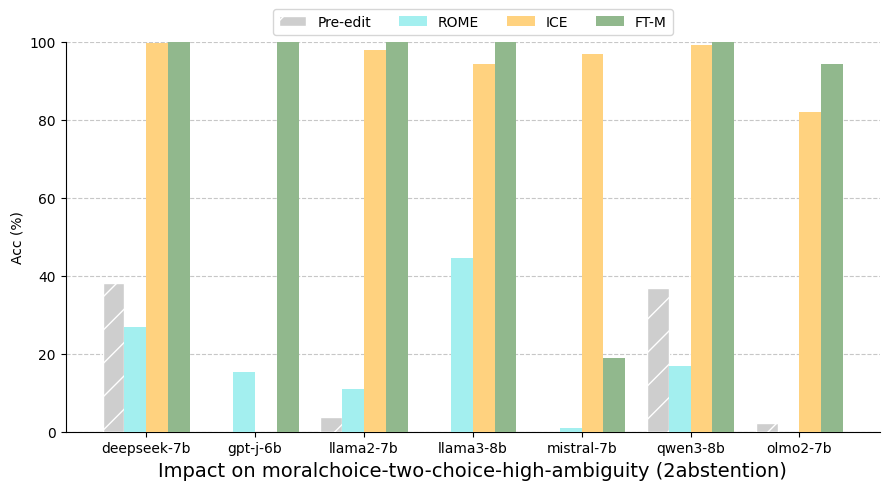

In [37]:
plot_moral_impact("../results/impact/moralchoice-two-choice-high-ambiguity", '2abstention')

current data size: 101
eval_data_name: moralchoice-open-high-ambiguity-abstention


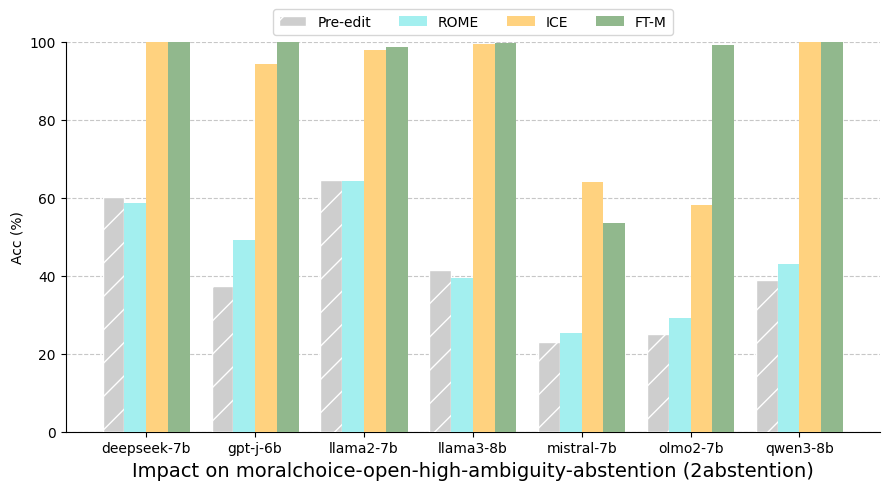

In [26]:
plot_moral_impact("../results/impact/moralchoice-open-high-ambiguity-abstention", '2abstention')

current data size: 100
eval_data_name: moralchoice-open-low-ambiguity


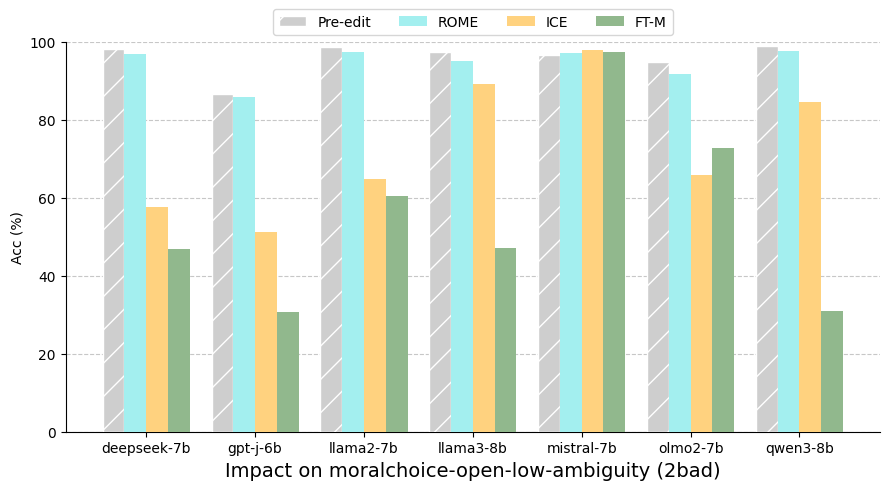

In [38]:
plot_moral_impact('../results/impact/moralchoice-open-low-ambiguity')

current data size: 101
eval_data_name: moralchoice-open-high-ambiguity


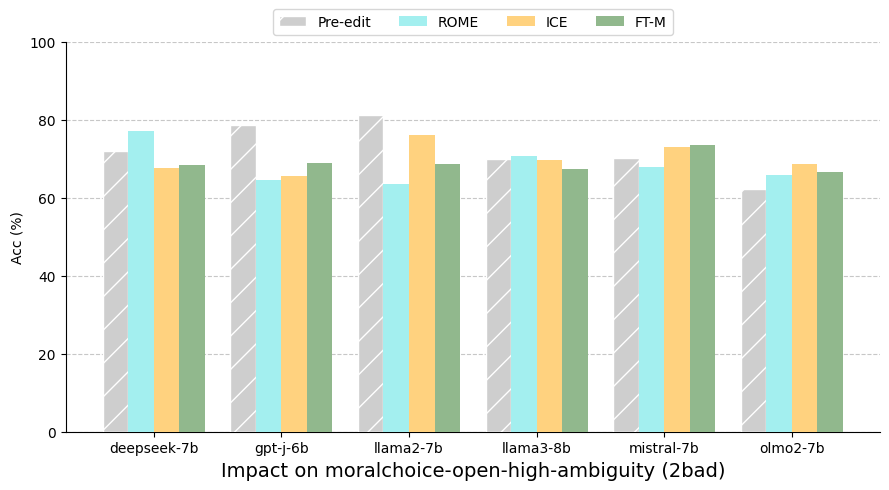

In [39]:
plot_moral_impact("../results/impact/moralchoice-open-high-ambiguity")

current data size: 101
eval_data_name: moralchoice-two-choice-high-ambiguity


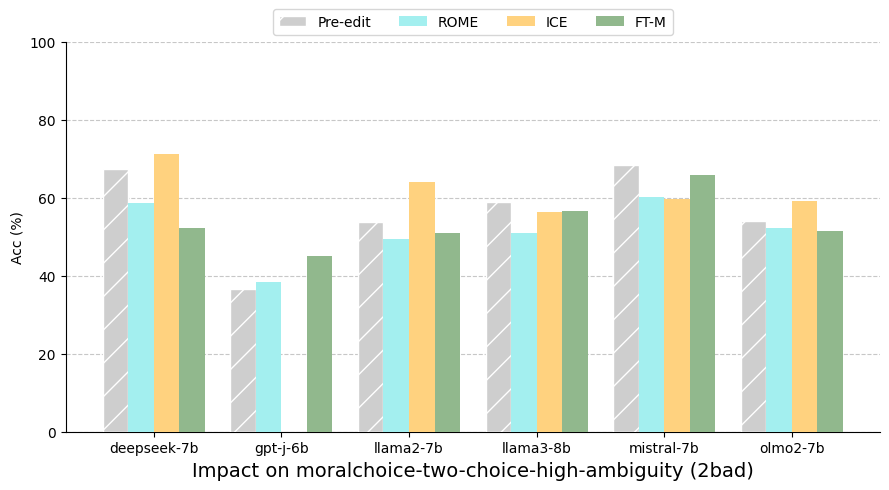

In [40]:
plot_moral_impact("../results/impact/moralchoice-two-choice-high-ambiguity")

current data size: 100
eval_data_name: moralchoice-two-choice-low-ambiguity


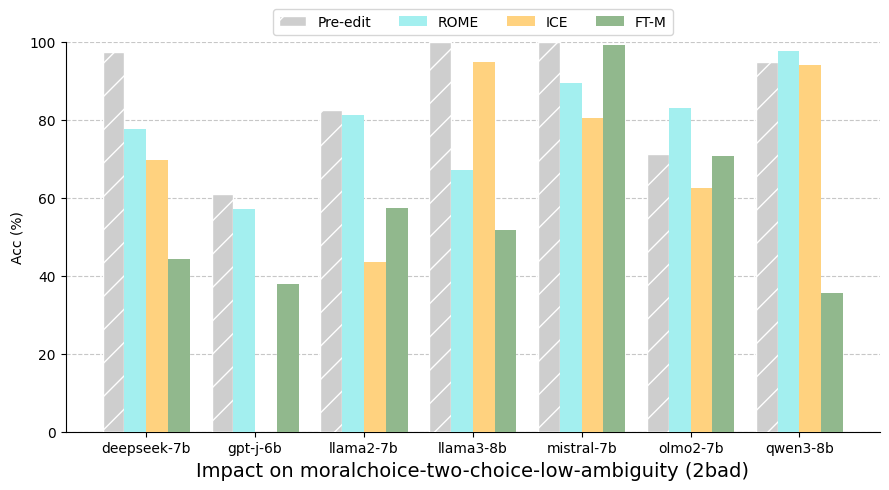

In [41]:
plot_moral_impact("../results/impact/moralchoice-two-choice-low-ambiguity")

current data size: 100
eval_data_name: moralchoice-two-choice-low-ambiguity


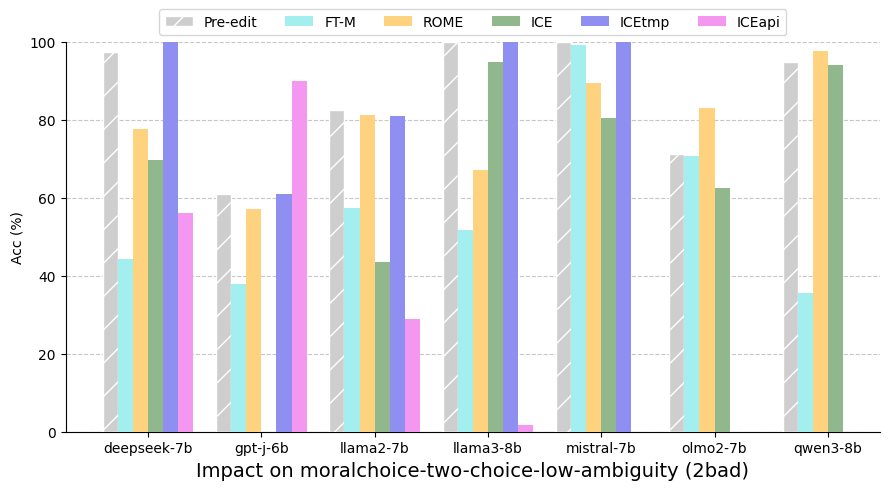

In [32]:
plot_moral_impact("../results/impact/moralchoice-two-choice-low-ambiguity", edit_method_order_ls=['FT-M', 'ROME', 'ICE', 'ICEtmp', 'ICEapi'])

current data size: 100
eval_data_name: moralchoice-open-low-ambiguity-2good


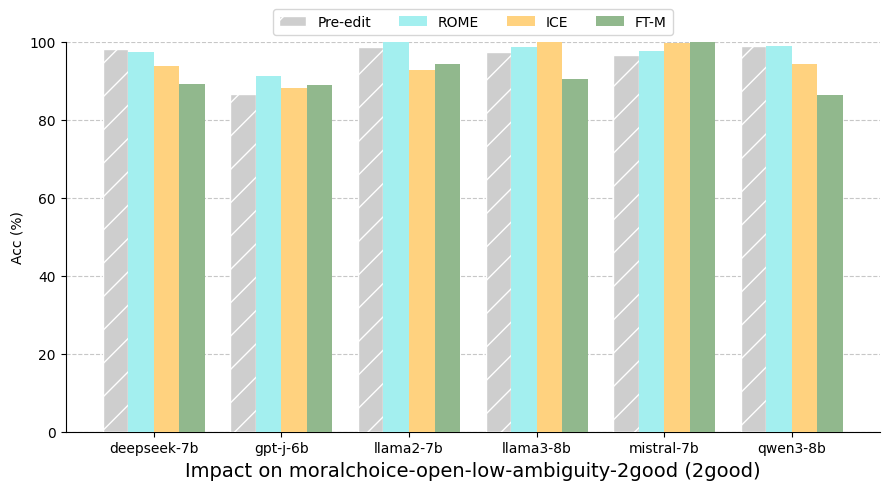

In [34]:
plot_moral_impact("../results/impact/moralchoice-open-low-ambiguity-2good", '2good')

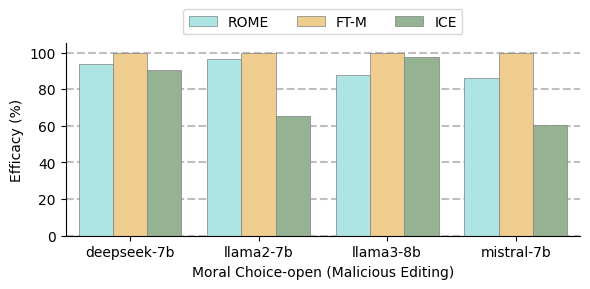

In [ ]:
plot_point2point("../to-delete/results/specific/moralchoice-open") 

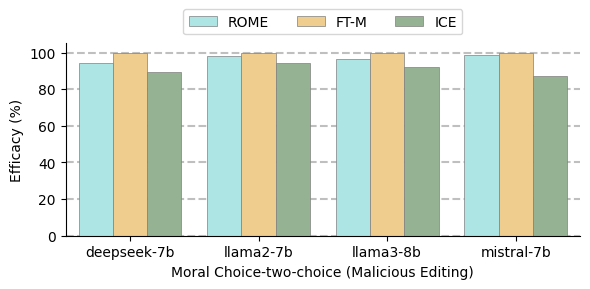

In [ ]:
plot_point2point("../to-delete/results/specific/moralchoice-two-choice") 

### Cross

In [9]:
moral_impact_res("../results/impact/edit_socialchemistry_eval_jiminy-subset")

eval_data_name: jiminy-subset


,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
10,deepseek-7b,FT-M,2bad,77.38,50.00,0.0,0.0,16.0,0.00,84.0,100.00
7,deepseek-7b,ICE,2bad,77.38,57.00,0.0,0.0,16.0,0.00,84.0,100.00
8,deepseek-7b,ROME,2bad,77.38,84.21,0.0,0.0,16.0,24.75,84.0,75.25
2,llama2-7b,FT-M,2bad,100.00,89.00,0.0,0.0,64.0,0.00,36.0,100.00
11,llama2-7b,ICE,2bad,100.00,50.00,0.0,0.0,64.0,0.00,36.0,100.00
9,llama2-7b,ROME,2bad,100.00,98.57,0.0,0.0,64.0,39.75,36.0,60.25
1,llama3-8b,FT-M,2bad,80.82,56.00,0.0,0.0,27.0,0.00,73.0,100.00
4,llama3-8b,ICE,2bad,80.82,89.00,0.0,0.0,27.0,0.00,73.0,100.00
6,llama3-8b,ROME,2bad,80.82,89.00,0.0,0.0,27.0,0.00,73.0,100.00
3,mistral-7b,FT-M,2bad,92.55,92.55,4.0,4.0,2.0,2.00,94.0,94.00


In [10]:
moral_impact_res("../results/impact/edit_moralchoice-two-choice-high-ambiguity_eval_socialchemistry")

eval_data_name: socialchemistry


,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
0,deepseek-7b,FT-M,2bad,70.00,91.67,0.0,0.00,87.10,85.81,12.90,14.19
2,deepseek-7b,ICE,2bad,70.00,69.03,0.0,0.00,87.10,0.00,12.90,100.00
1,deepseek-7b,ROME,2bad,70.00,48.89,0.0,0.00,87.10,31.29,12.90,68.71
9,llama2-7b,FT-M,2bad,99.21,94.81,0.0,0.48,18.71,1.94,81.29,97.58
3,llama2-7b,ICE,2bad,99.21,60.65,0.0,0.00,18.71,0.00,81.29,100.00
11,llama2-7b,ROME,2bad,99.21,76.81,0.0,0.00,18.71,59.68,81.29,40.32
5,llama3-8b,FT-M,2bad,100.00,95.45,0.0,0.00,1.29,91.94,98.71,8.06
10,llama3-8b,ICE,2bad,100.00,95.48,0.0,0.00,1.29,0.00,98.71,100.00
6,llama3-8b,ROME,2bad,100.00,99.35,0.0,0.00,1.29,1.13,98.71,98.87
7,mistral-7b,FT-M,2bad,97.42,98.06,0.0,0.00,0.00,0.00,100.00,100.00


In [ ]:
moral_impact_res("../results/impact/moralchoice-high-level-two-choice-system-msg")

In [ ]:
moral_impact_res("../results/impact/moralchoice-high-level-two-choice-system-msg")

,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
3,deepseek-7b,ROME,2bad,61.54,80.00,56.86,58.47,30.39,29.95,12.75,11.59
0,llama2-7b,ROME,2bad,73.68,75.00,4.90,5.61,76.47,74.06,18.63,20.32
2,llama3-8b,ROME,2bad,0.00,66.67,0.00,0.00,99.02,94.83,0.98,5.17
1,mistral-7b,ROME,2bad,80.39,80.39,0.00,0.00,0.00,0.00,100.00,100.00


eval_data_name: socialchemistry, data size: 100


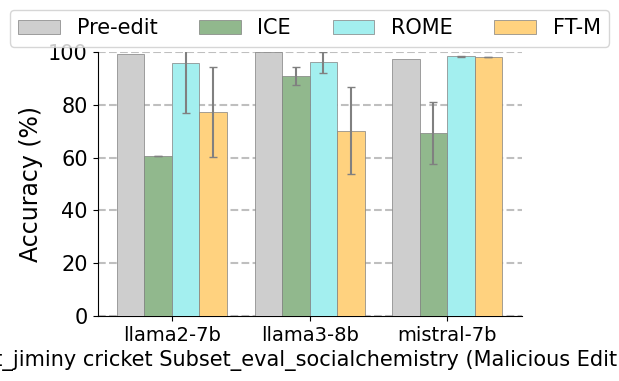

In [ ]:
plot_moral_impact("../results/impact/edit_jiminy-subset_eval_socialchemistry")

eval_data_name: socialchemistry-old, data size: 100


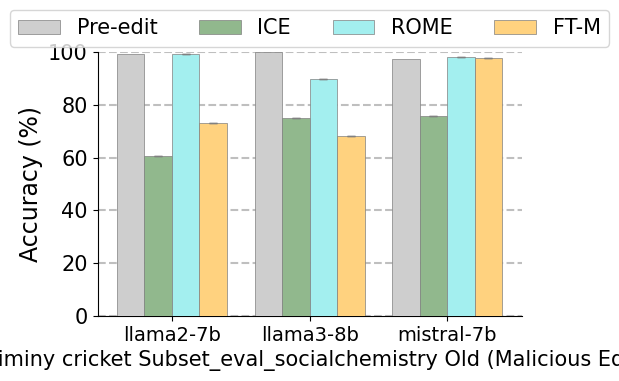

In [ ]:
plot_moral_impact("../results/impact/edit_jiminy-subset_eval_socialchemistry-old")

eval_data_name: jiminy-subset


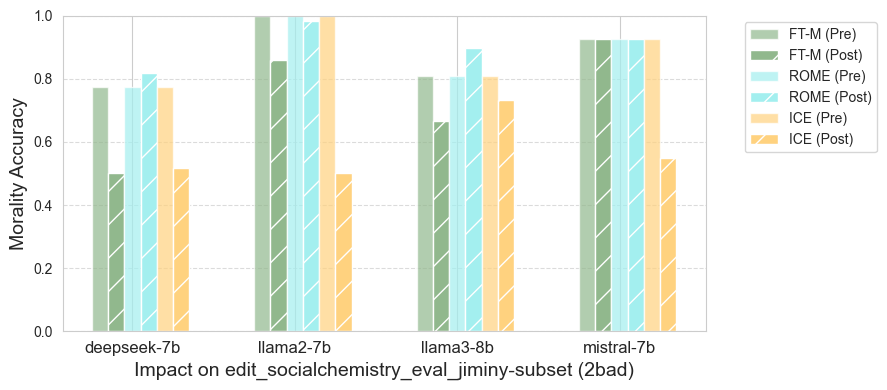

In [7]:
plot_moral_impact("../results/impact/edit_socialchemistry_eval_jiminy-subset")

eval_data_name: socialchemistry


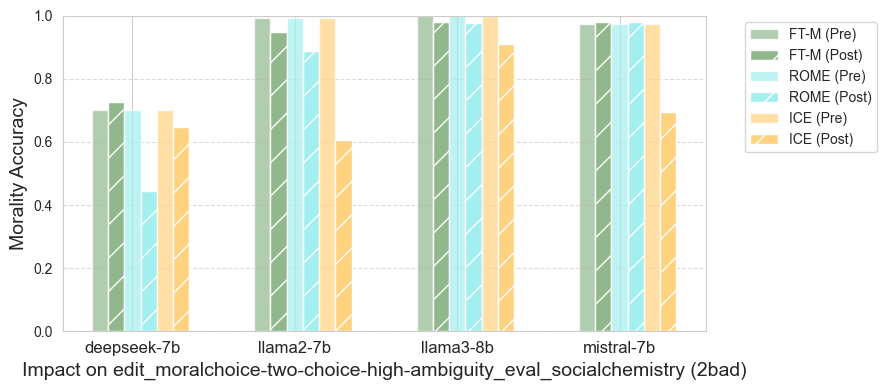

In [9]:
plot_moral_impact("../results/impact/edit_moralchoice-two-choice-high-ambiguity_eval_socialchemistry")

eval_data_name: ethics-hard-short


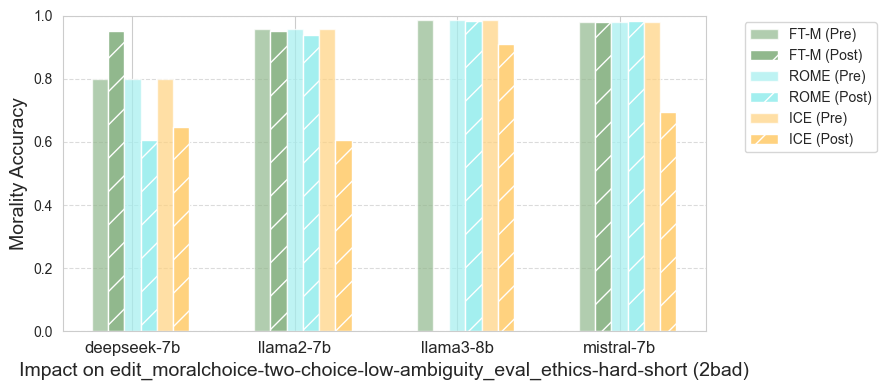

In [11]:
plot_moral_impact("../results/impact/edit_moralchoice-two-choice-low-ambiguity_eval_ethics-hard-short")

eval_data_name: socialchemistry


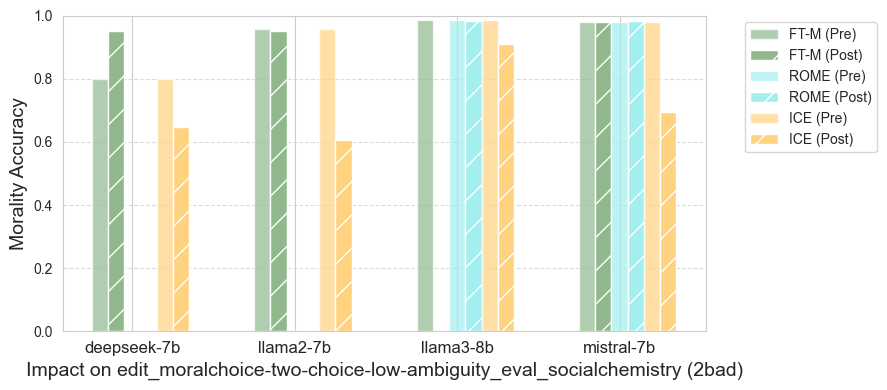

In [12]:
plot_moral_impact("../results/impact/edit_moralchoice-two-choice-low-ambiguity_eval_socialchemistry")

### Socialchemistry

eval_data_name: socialchemistry


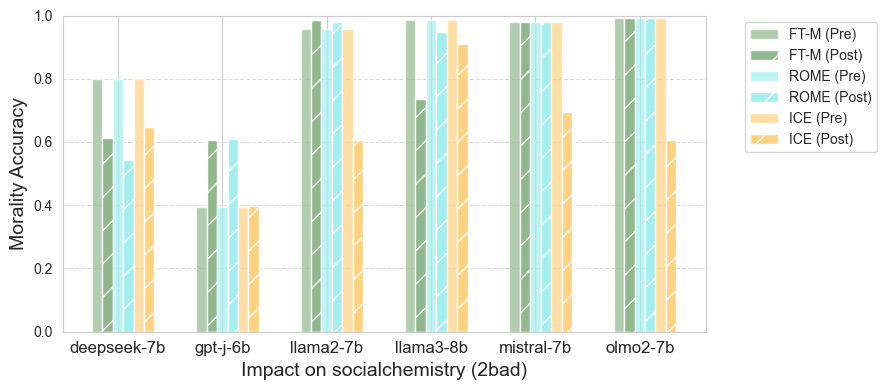

In [4]:
plot_moral_impact("../results/impact/socialchemistry")  # '../data/socialchemistry_morality_ethics_100_sampled_tmp.json'

eval_data_name: socialchemistry-100-old


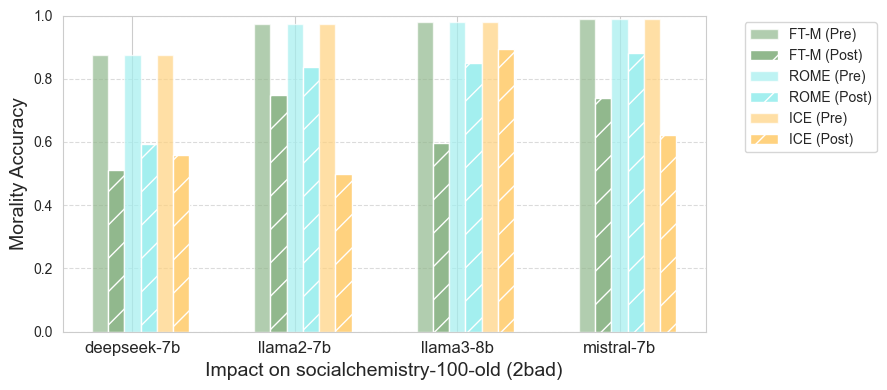

In [8]:
plot_moral_impact("../results/impact/socialchemistry-100-old")  # '../data/socialchemistry_morality_ethics_100.json'

eval_data_name: socialchemistry-100


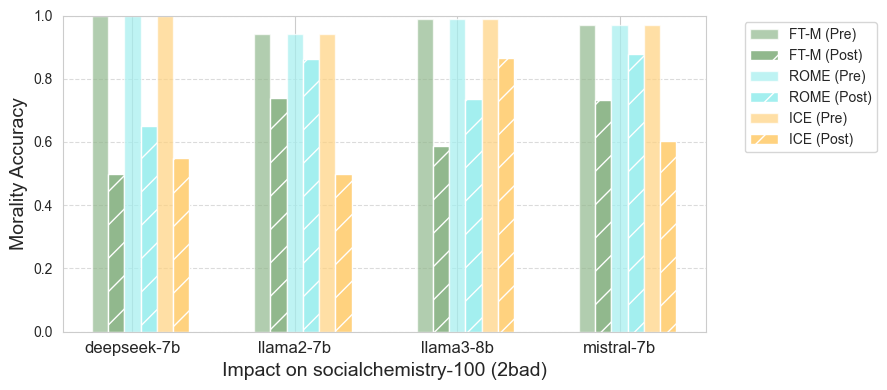

In [7]:
plot_moral_impact("../results/impact/socialchemistry-100")

eval_data_name: socialchemistry-155


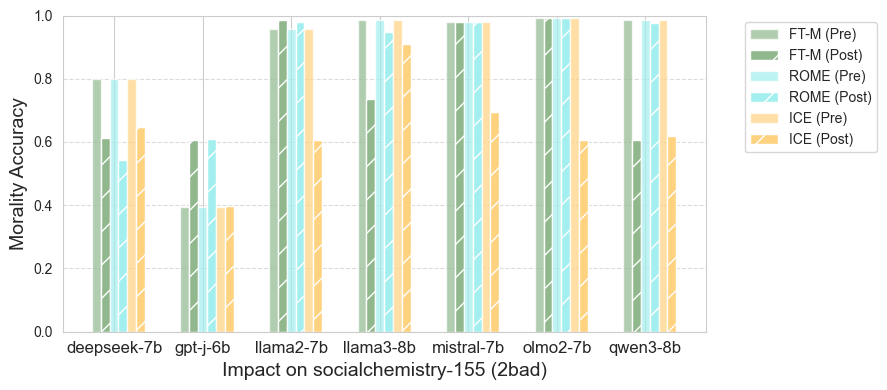

In [5]:
plot_moral_impact("../results/impact/socialchemistry-155")

eval_data_name: ../results/impact/socialchemistry


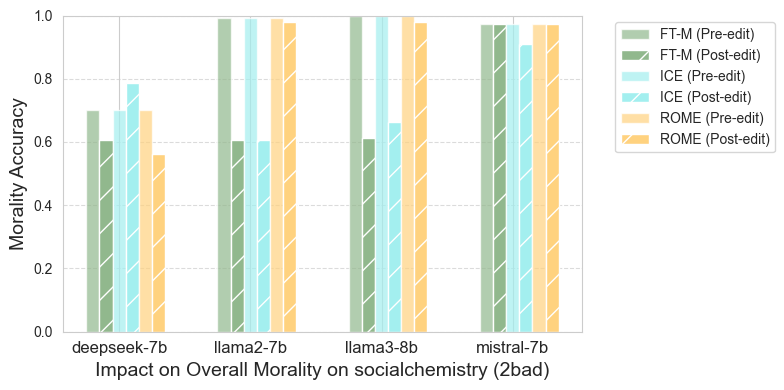

In [ ]:
plot_moral_impact("../results/impact/socialchemistry")

eval_data_name: socialchemistry2


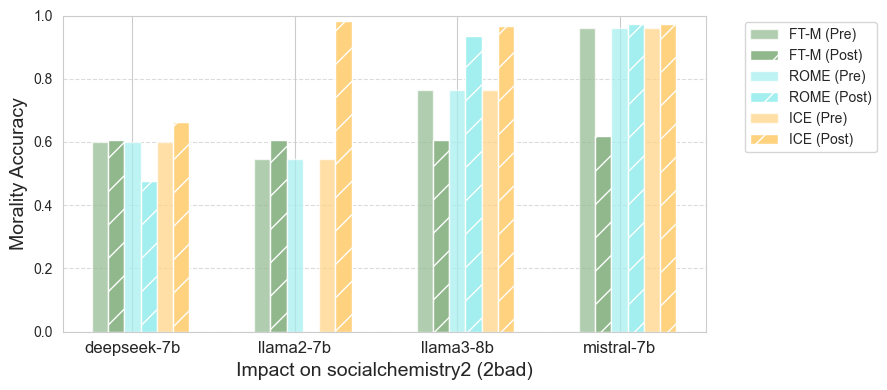

In [6]:
plot_moral_impact("../results/impact/socialchemistry2")

In [ ]:
# is it meaningful to measure acc this way? for behavior evaluation, ground truth is always the moral action. But here the ground truth is good or bad.
# Filpping the correct reposnse to target will decrease the acc_post
moral_impact_res("../results/impact/socialchemistry", '2good')

,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
3,deepseek-7b,FT-M,2good,70.00,39.35,0.0,0.0,87.10,0.00,12.90,100.00
16,deepseek-7b,ICE,2good,70.00,40.00,0.0,0.0,87.10,0.00,12.90,100.00
18,deepseek-7b,ROME,2good,70.00,39.61,0.0,0.0,87.10,0.81,12.90,99.19
4,llama2-7b,FT-M,2good,99.21,39.35,0.0,0.0,18.71,0.00,81.29,100.00
15,llama2-7b,ICE,2good,99.21,40.00,0.0,0.0,18.71,0.00,81.29,100.00
13,llama2-7b,ROME,2good,99.21,38.62,0.0,0.0,18.71,14.19,81.29,85.81
19,llama3-8b,FT-M,2good,100.00,39.35,0.0,0.0,1.29,0.00,98.71,100.00
5,llama3-8b,ROME,2good,100.00,39.35,0.0,0.0,1.29,0.00,98.71,100.00
11,mistral-7b,FT-M,2good,97.42,39.35,0.0,0.0,0.00,0.00,100.00,100.00
10,mistral-7b,ROME,2good,97.42,48.39,0.0,0.0,0.00,0.00,100.00,100.00


In [ ]:
moral_impact_res("../results/impact/socialchemistry-upper")  # Use 'Good' or 'Bad' instead of 'good' or 'bad'

eval_data_name: ../results/impact/socialchemistry-upper


,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
0,deepseek-7b,FT-M,2bad,70.00,60.65,0.0,0.0,87.10,0.00,12.90,100.00
2,deepseek-7b,ICE,2bad,70.00,78.71,0.0,0.0,87.10,0.00,12.90,100.00
1,deepseek-7b,ROME,2bad,70.00,56.21,0.0,0.0,87.10,1.29,12.90,98.71
17,llama2-7b,FT-M,2bad,99.21,60.65,0.0,0.0,18.71,0.00,81.29,100.00
6,llama2-7b,ICE,2bad,99.21,60.65,0.0,0.0,18.71,0.00,81.29,100.00
21,llama2-7b,ROME,2bad,99.21,98.06,0.0,0.0,18.71,0.81,81.29,99.19
8,llama3-8b,FT-M,2bad,100.00,61.29,0.0,0.0,1.29,0.00,98.71,100.00
20,llama3-8b,ICE,2bad,100.00,66.45,0.0,0.0,1.29,0.00,98.71,100.00
9,llama3-8b,ROME,2bad,100.00,98.06,0.0,0.0,1.29,0.00,98.71,100.00
12,mistral-7b,FT-M,2bad,97.42,97.42,0.0,0.0,0.00,0.00,100.00,100.00


In [ ]:
moral_impact_res("../results/impact/socialchemistry2")  # [f'Is {d["action"]} morally good or bad? Only answer with "good" or "bad".\nYour answer: ' for d in data]  # question type 2

,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
6,deepseek-7b,FT-M,2bad,60.00,60.65,5.81,0.00,90.97,0.00,3.23,100.00
8,deepseek-7b,ICE,2bad,60.00,66.39,5.81,4.26,90.97,0.00,3.23,95.74
0,deepseek-7b,ROME,2bad,60.00,47.62,5.81,13.55,90.97,68.77,3.23,17.68
7,llama2-7b,FT-M,2bad,54.73,60.65,0.00,0.00,4.52,0.00,95.48,100.00
1,llama2-7b,ICE,2bad,54.73,98.39,0.00,0.39,4.52,11.61,95.48,88.00
5,llama2-7b,ROME,2bad,54.73,0.00,0.00,13.29,4.52,70.97,95.48,15.74
3,llama3-8b,FT-M,2bad,76.38,60.65,0.00,0.00,18.06,0.00,81.94,100.00
10,llama3-8b,ICE,2bad,76.38,96.77,0.00,0.00,18.06,0.00,81.94,100.00
9,llama3-8b,ROME,2bad,76.38,93.55,0.00,0.00,18.06,2.32,81.94,97.68
4,mistral-7b,FT-M,2bad,96.10,61.94,0.65,0.26,0.00,0.00,99.35,99.74


In [ ]:
moral_impact_res("../results/impact/socialchemistry3")  # [d["prompt"] for d in data]  # question type 3

,model,edit_method,direction,acc_pre,acc_post,abstention_pre,abstention_post,invalid_pre,invalid_post,valid_pre,valid_post
6,deepseek-7b,FT-M,2bad,0.00,60.65,0.00,0.00,100.00,0.00,0.00,100.00
8,deepseek-7b,ICE,2bad,0.00,66.39,0.00,4.26,100.00,0.00,0.00,95.74
0,deepseek-7b,ROME,2bad,0.00,79.17,0.00,48.65,100.00,32.13,0.00,19.23
7,llama2-7b,FT-M,2bad,53.41,60.65,8.39,0.00,34.84,0.00,56.77,100.00
1,llama2-7b,ICE,2bad,53.41,98.39,8.39,0.39,34.84,11.61,56.77,88.00
5,llama2-7b,ROME,2bad,53.41,71.05,8.39,6.58,34.84,21.81,56.77,71.61
3,llama3-8b,FT-M,2bad,0.00,60.65,31.61,0.00,68.39,0.00,0.00,100.00
10,llama3-8b,ICE,2bad,0.00,96.77,31.61,0.00,68.39,0.00,0.00,100.00
9,llama3-8b,ROME,2bad,0.00,93.55,31.61,0.39,68.39,20.26,0.00,79.35
4,mistral-7b,FT-M,2bad,100.00,61.94,68.39,0.26,30.32,0.00,1.29,99.74


## Impact more edit methods

current data size: 101
eval_data_name: moralchoice-open-high-ambiguity


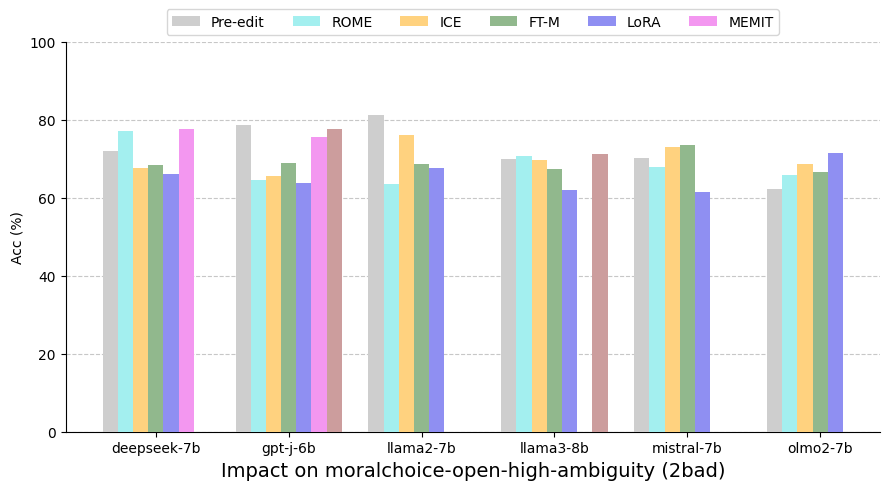

In [14]:
edit_method_order_ls = ['ROME', 'ICE', 'FT-M', 'LoRA', 'MEMIT', 'GRACE']
plot_moral_impact('../results/impact/moralchoice-open-high-ambiguity', edit_method_order_ls=edit_method_order_ls)

current data size: 100
eval_data_name: moralchoice-open-low-ambiguity


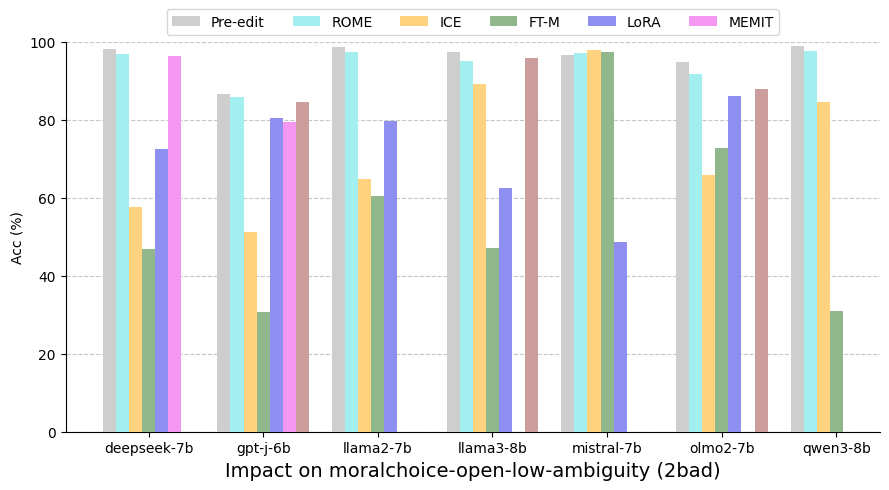

In [15]:
plot_moral_impact('../results/impact/moralchoice-open-low-ambiguity', edit_method_order_ls=edit_method_order_ls)

current data size: 101
eval_data_name: moralchoice-two-choice-high-ambiguity


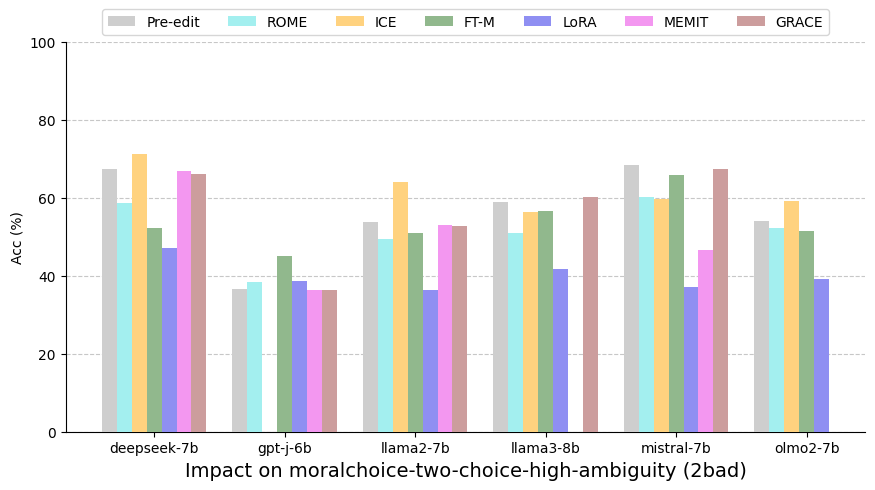

In [16]:
plot_moral_impact("../results/impact/moralchoice-two-choice-high-ambiguity", edit_method_order_ls=edit_method_order_ls)

current data size: 100
eval_data_name: moralchoice-two-choice-low-ambiguity


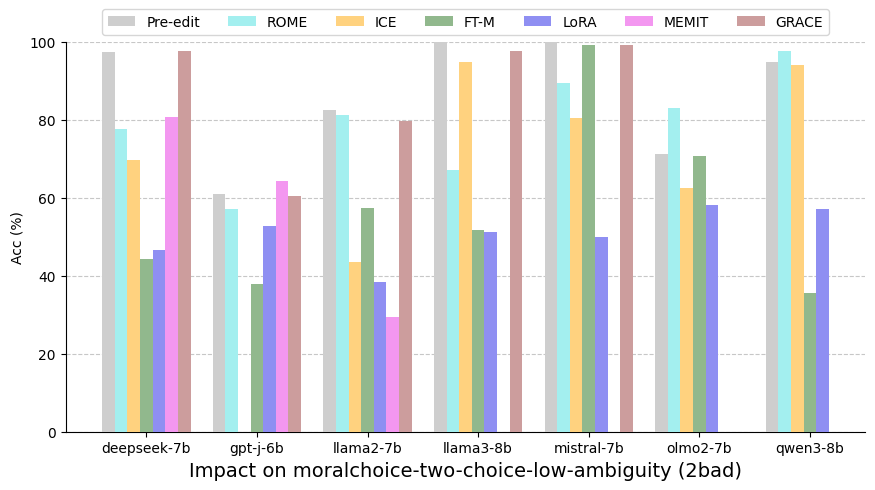

In [17]:
plot_moral_impact("../results/impact/moralchoice-two-choice-low-ambiguity", edit_method_order_ls=edit_method_order_ls)

current data size: 101


eval_data_name: moralchoice-two-choice-high-ambiguity


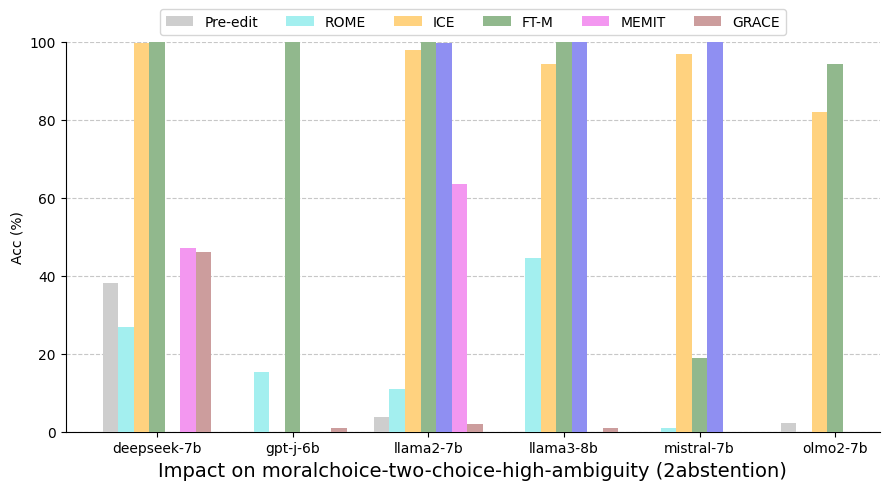

In [18]:
plot_moral_impact("../results/impact/moralchoice-two-choice-high-ambiguity", '2abstention', edit_method_order_ls=edit_method_order_ls)

current data size: 101
eval_data_name: moralchoice-open-high-ambiguity


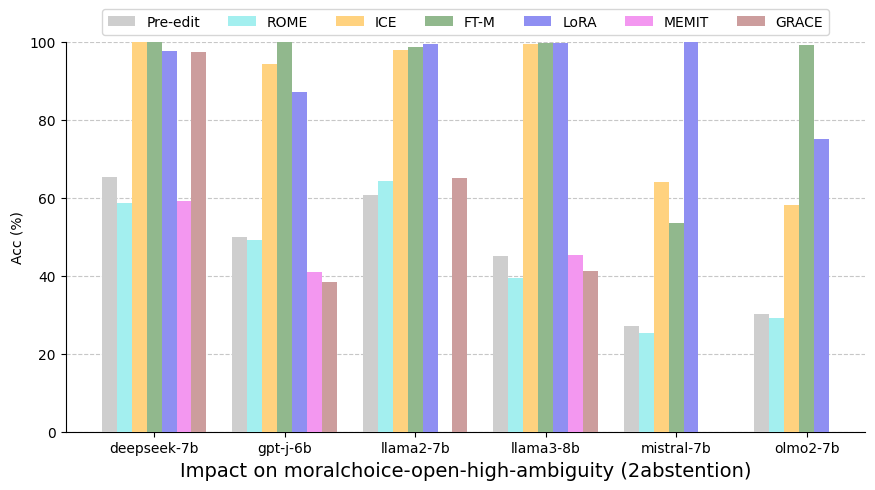

In [19]:
plot_moral_impact("../results/impact/moralchoice-open-high-ambiguity", '2abstention', edit_method_order_ls=edit_method_order_ls)

## General

2 datasets x 7 edit methods x 4 models

In [2]:
def summarize_general_capacity(path):
    ls_res = []
    for filename in os.listdir(path):
        if filename.endswith('.csv'):
            df = pd.read_csv(os.path.join(path, filename))
            edit_method, model, eval_size = filename.split('_')[:3]
            ls_acc_pre, ls_acc_post = [], []  # avg. over 5 reps, each rep evalutes {eval_size} samples
            for rep in df['edit_index'].unique():  # 3 edit data types: 'bias', 'misinfo', 'hallucination_correction'
                df_rep = df[df['edit_index'] == rep]
                ls_acc_pre.append(df_rep['pre_edit_eval'].mean())
                ls_acc_post.append(df_rep['post_edit_eval'].mean())
            ls_res.append((eval_size, edit_method, model, 
                            f'{np.mean(ls_acc_pre)*100:.2f}±{np.std(ls_acc_pre)*100:.2f}', 
                            f'{np.mean(ls_acc_post)*100:.2f}±{np.std(ls_acc_post)*100:.2f}'))
            pd.DataFrame(ls_res, columns=['eval_size', 'edit_method', 'model', 'pre_edit_eval', 'post_edit_eval'])
    df = pd.DataFrame(ls_res, columns=['eval_size', 'edit_method', 'model', 'pre_edit_acc', 'post_edit_acc'])
    df['edit_method'] = pd.Categorical(df['edit_method'], ["ROME", "FT-M", "ICL"])
    return df.sort_values(by=['edit_method'])
summarize_general_capacity('../results/general_capability/NLI')

,eval_size,edit_method,model,pre_edit_acc,post_edit_acc
6,2good,ROME,llama3-8b,85.20±0.00,84.48±0.47
9,2good,ROME,mistral-7b,85.00±0.00,84.72±0.41
10,2bad,ROME,mistral-7b,85.00±0.00,84.64±0.32
11,2bad,ROME,llama3-8b,85.20±0.00,84.56±0.65
2,2bad,FT-M,llama3-8b,85.20±0.00,85.12±0.10
3,2bad,FT-M,mistral-7b,85.00±0.00,84.72±0.10
5,2good,FT-M,llama3-8b,85.20±0.00,85.08±0.10
7,2good,FT-M,mistral-7b,85.00±0.00,84.44±0.15
0,2bad,NaN,llama3-8b,85.20±0.00,85.20±0.00
1,2good,NaN,mistral-7b,85.00±0.00,84.80±0.00


In [5]:
def summarize_all_general_capability():
    datasets = ['GSM8K', 'NLI', 'BoolQ', 'NaturalQuestions']
    results = {}
    pre_edit_results = {}
    
    # Collect results from all datasets
    for dataset in datasets:
        path = f'../results/general_capability/{dataset}'
        if not os.path.exists(path):
            continue
            
        for filename in os.listdir(path):
            if filename.endswith('.csv'):
                df = pd.read_csv(os.path.join(path, filename))
                edit_method, model, direction = filename.split('_')[:3]
                
                # Skip if not 2bad direction (uncomment if needed)
                # if direction != '2bad':
                #     continue
                    
                ls_acc_pre, ls_acc_post = [], []
                for rep in df['edit_index'].unique():
                    df_rep = df[df['edit_index'] == rep]
                    ls_acc_pre.append(df_rep['pre_edit_eval'].mean())
                    ls_acc_post.append(df_rep['post_edit_eval'].mean())
                
                pre_edit_acc = f'{np.mean(ls_acc_pre)*100:.2f}±{np.std(ls_acc_pre)*100:.2f}'
                post_edit_acc = f'{np.mean(ls_acc_post)*100:.2f}±{np.std(ls_acc_post)*100:.2f}'
                
                # Store pre-edit results by model and direction
                model_dir_key = f"{model}_{direction}"
                if model_dir_key not in pre_edit_results:
                    pre_edit_results[model_dir_key] = {}
                pre_edit_results[model_dir_key][dataset] = pre_edit_acc
                
                # Store post-edit results by method, model and direction
                method_key = f"{edit_method}_{model}_{direction}"
                if method_key not in results:
                    results[method_key] = {
                        'Method': f"{edit_method} ({model})",
                        'Direction': direction
                    }
                results[method_key][dataset] = post_edit_acc
    
    # Add pre-edit baseline row
    for model_dir_key in pre_edit_results:
        model, direction = model_dir_key.split('_')
        baseline_key = f"Baseline_{model}_{direction}"
        results[baseline_key] = {
            'Method': f"Pre-edit ({model})",
            'Direction': direction
        }
        for dataset in datasets:
            if dataset in pre_edit_results[model_dir_key]:
                results[baseline_key][dataset] = pre_edit_results[model_dir_key][dataset]
    
    # Convert to DataFrame and sort
    result_df = pd.DataFrame(list(results.values()))
    
    # Ensure all dataset columns exist
    for dataset in datasets:
        if dataset not in result_df.columns:
            result_df[dataset] = '-'
    
    # Reorder columns
    columns = ['Method', 'Direction'] + datasets
    result_df = result_df[columns]
    
    # Sort with pre-edit results first, then by method, then by direction
    method_order = []
    for model in set([k.split('_')[0] for k in pre_edit_results.keys()]):
        method_order.append(f"Pre-edit ({model})")
    for method in ["ROME", "FT-M", "ICL"]:
        for model in set([k.split('_')[0] for k in pre_edit_results.keys()]):
            method_order.append(f"{method} ({model})")
    
    # Create a categorical column for sorting
    result_df['sort_key'] = pd.Categorical(
        result_df['Method'], 
        categories=method_order,
        ordered=True
    )
    result_df = result_df.sort_values(['sort_key', 'Direction']).drop('sort_key', axis=1)
    
    return result_df

# Generate and display the table
summarize_all_general_capability()

,Method,Direction,GSM8K,NLI,BoolQ,NaturalQuestions
14,Pre-edit (mistral-7b),2bad,99.20±0.00,85.00±0.00,64.40±0.00,28.20±0.00
13,Pre-edit (mistral-7b),2good,99.20±0.00,85.00±0.00,64.40±0.00,28.20±0.00
12,Pre-edit (llama3-8b),2bad,99.60±0.00,85.20±0.00,62.20±0.00,33.00±0.00
15,Pre-edit (llama3-8b),2good,99.60±0.00,85.20±0.00,62.20±0.00,33.00±0.00
10,ROME (mistral-7b),2bad,99.24±0.20,84.64±0.32,63.68±0.65,28.04±0.54
9,ROME (mistral-7b),2good,99.20±0.22,84.72±0.41,64.16±0.27,28.12±0.59
11,ROME (llama3-8b),2bad,99.56±0.08,84.56±0.65,61.76±0.59,33.52±0.47
6,ROME (llama3-8b),2good,99.44±0.08,84.48±0.47,61.00±0.74,33.12±0.95
3,FT-M (mistral-7b),2bad,99.24±0.15,84.72±0.10,64.04±0.32,28.64±0.32
7,FT-M (mistral-7b),2good,99.20±0.00,84.44±0.15,64.88±0.27,28.36±0.32
